In [1]:
import ozzy as oz
import matplotlib.pyplot as plt # noqa
import ozzy.plot as oplot # noqa
import ozzy.fields as flds # noqa
import numpy as np
import xarray as xr
# import seaborn as sns

# sns.set_context('notebook')

In [28]:
# path = "/Volumes/Mariana/Simulations/LCODE/gap_position_scan/from_002400/10m_noramp/xi_Ez_concat.h5"
path = "~/cernbox/Simulations/LCODE/gap_position_scan/from_002400/10m_noramp/xi_Ez_concat.h5"
ds = oz.open('ozzy', path)
# ds = ds["xi_Ez"].sel(x1=slice(-200.0, 0.0))

# ds_v = oz.open('ozzy', '../vphi_100.h5')

ds_vphi = flds.vphi_from_xcorr(ds['xi_Ez'], window_len=3.0)


Reading the following files:
    -> 'read' took: 0:00:00.023456

Calculating the phase...


100%|██████████| 132/132 [01:11<00:00,  1.85it/s]


Calculating the phase velocity...

Done!


## Correlation - plot results

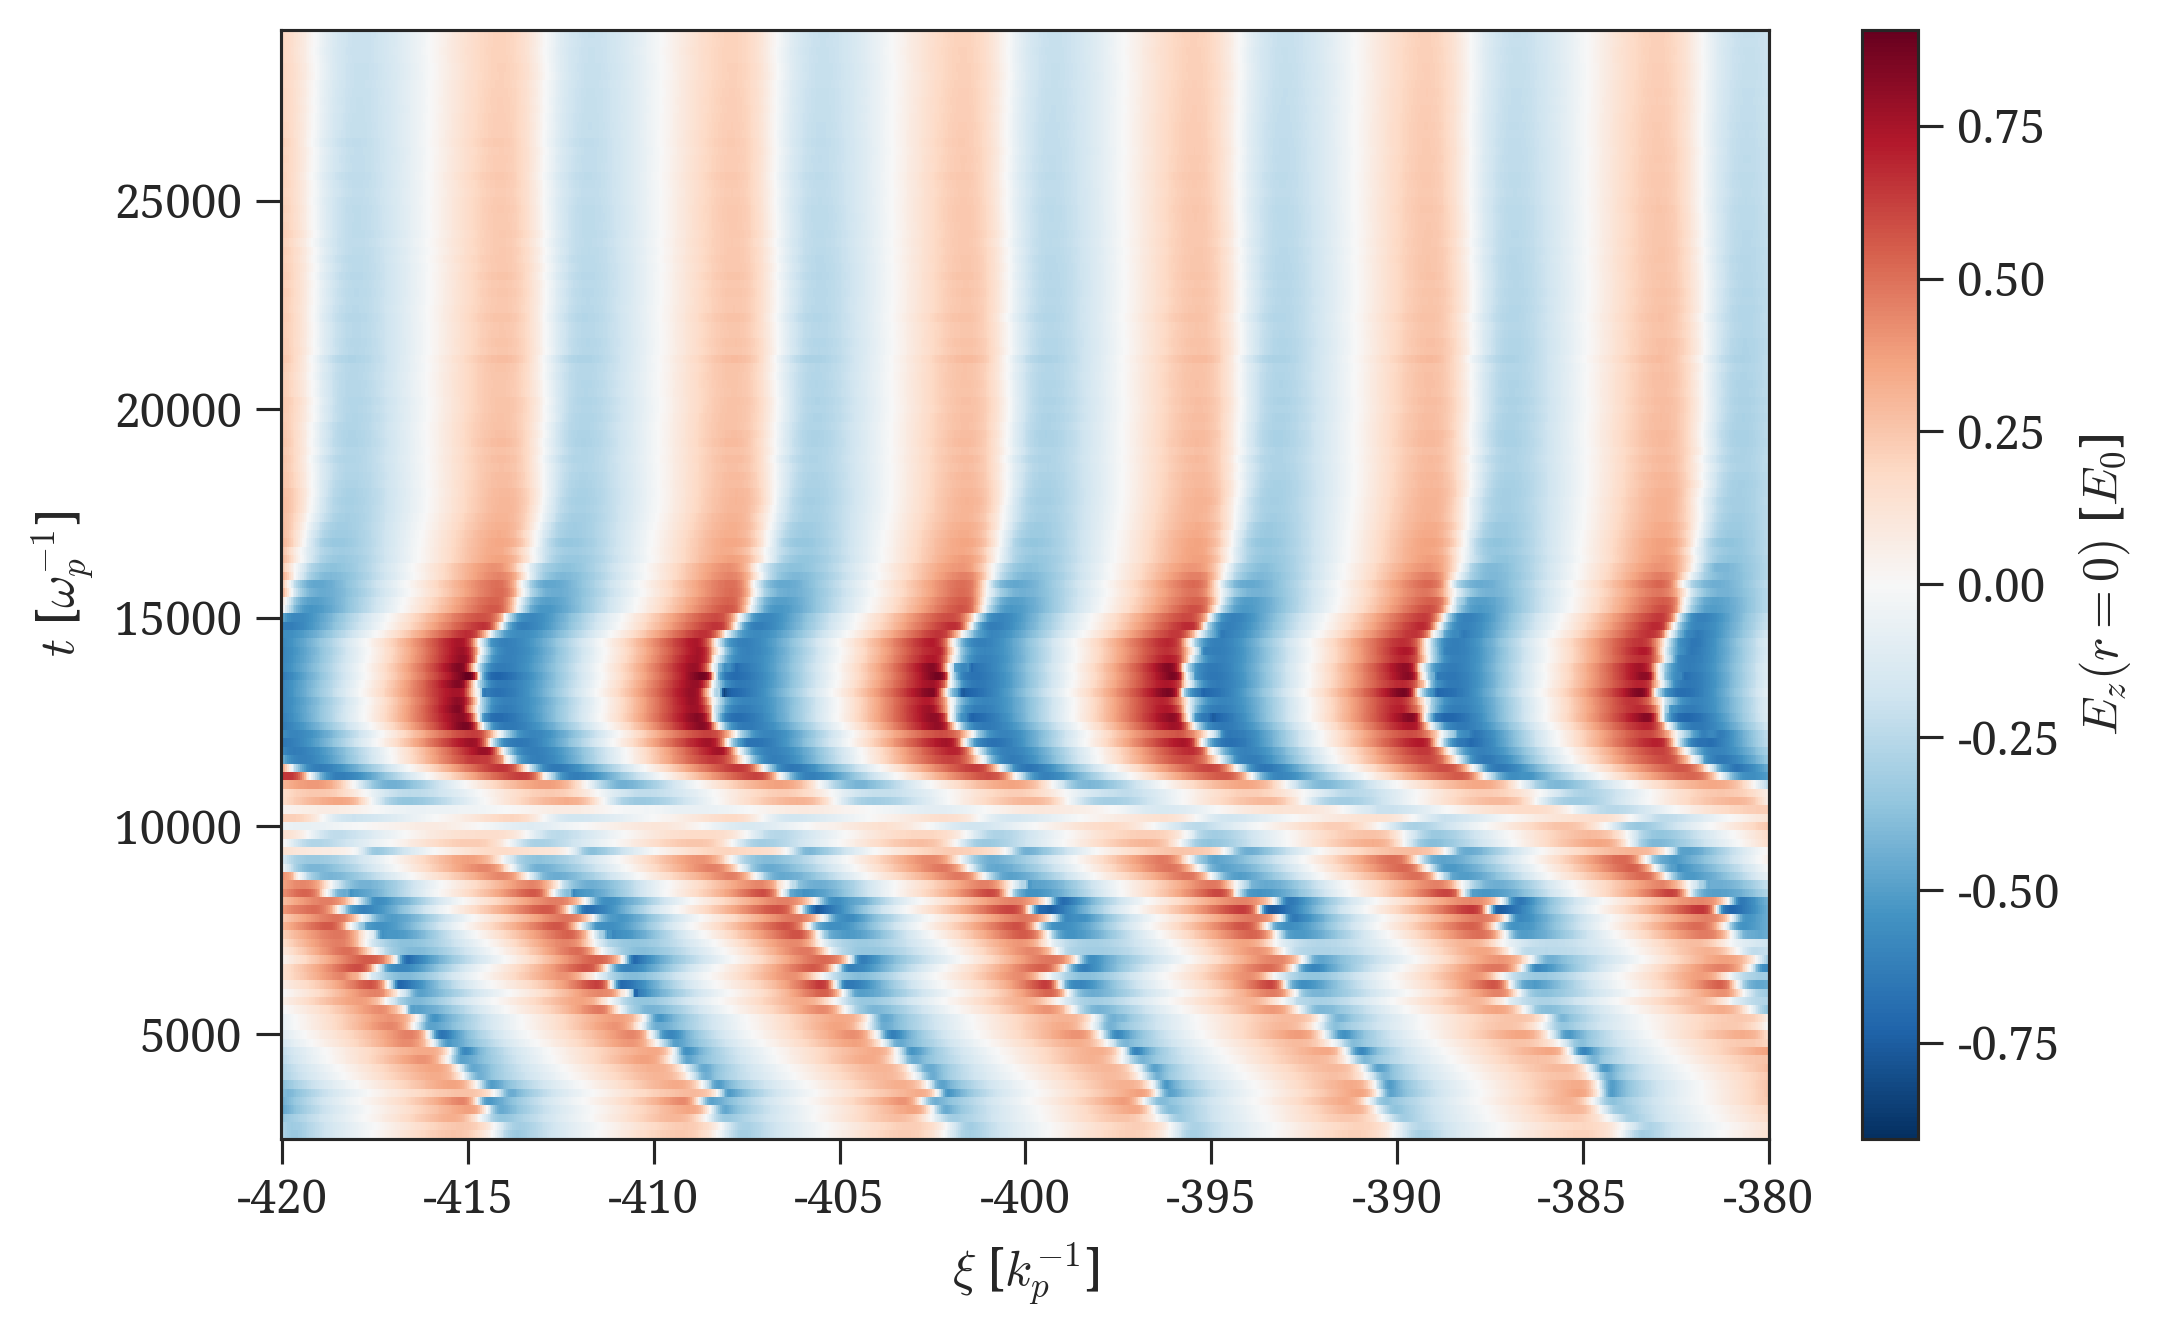

In [29]:
ds['xi_Ez'].sel(x1=slice(-420,-380)).plot()

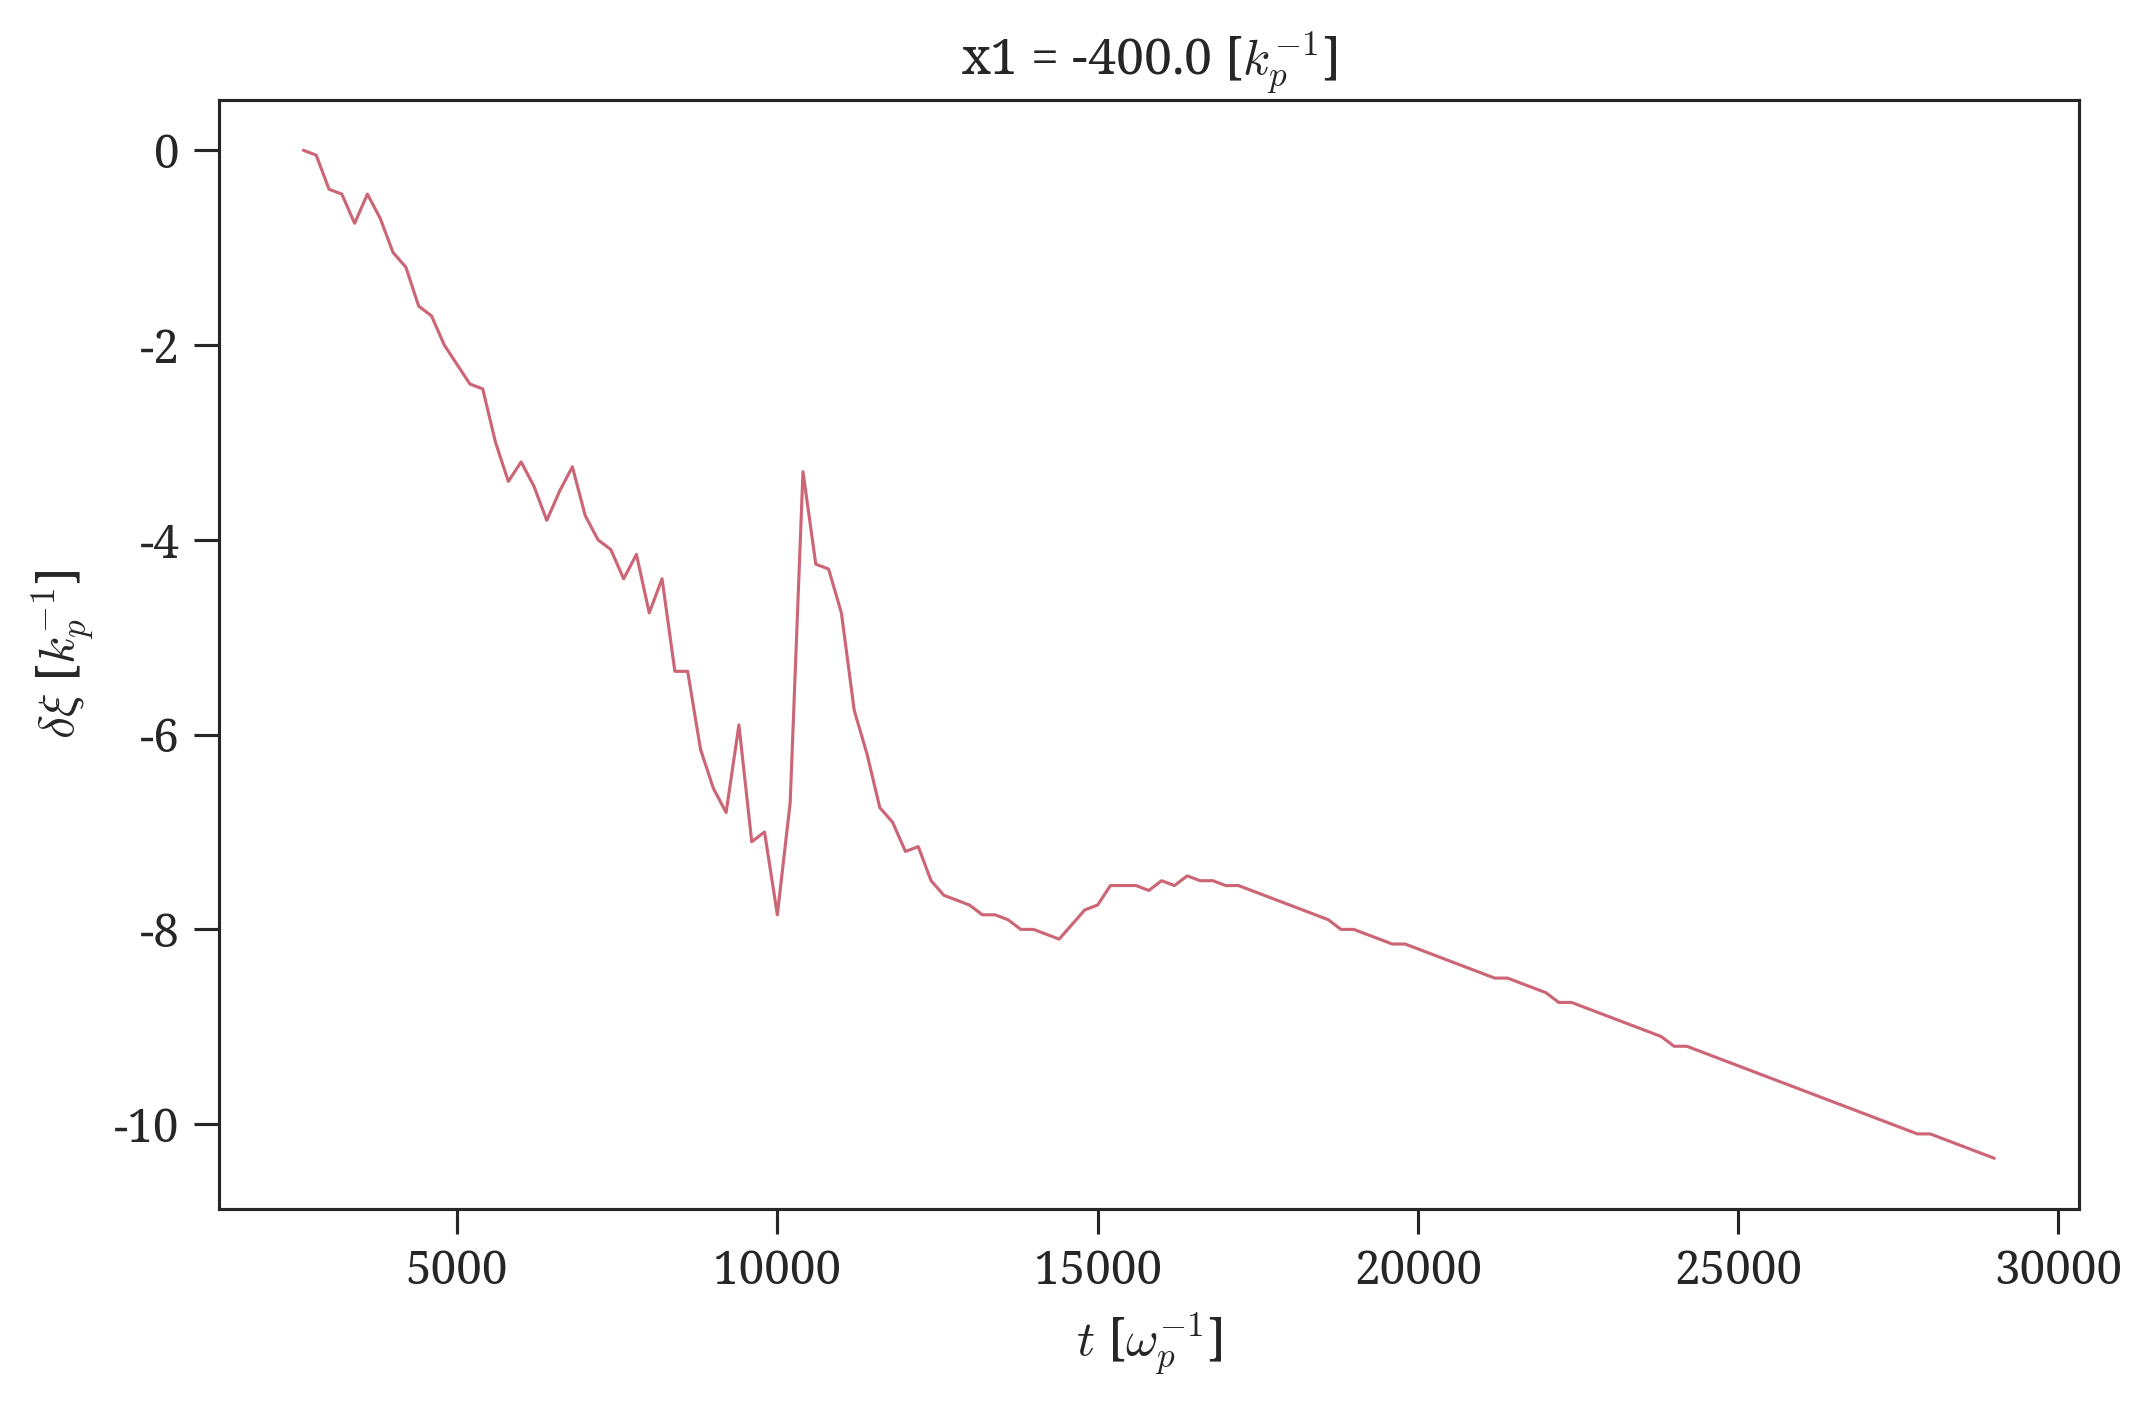

In [30]:
ds_vphi["shift"].sel(x1=-400).plot()

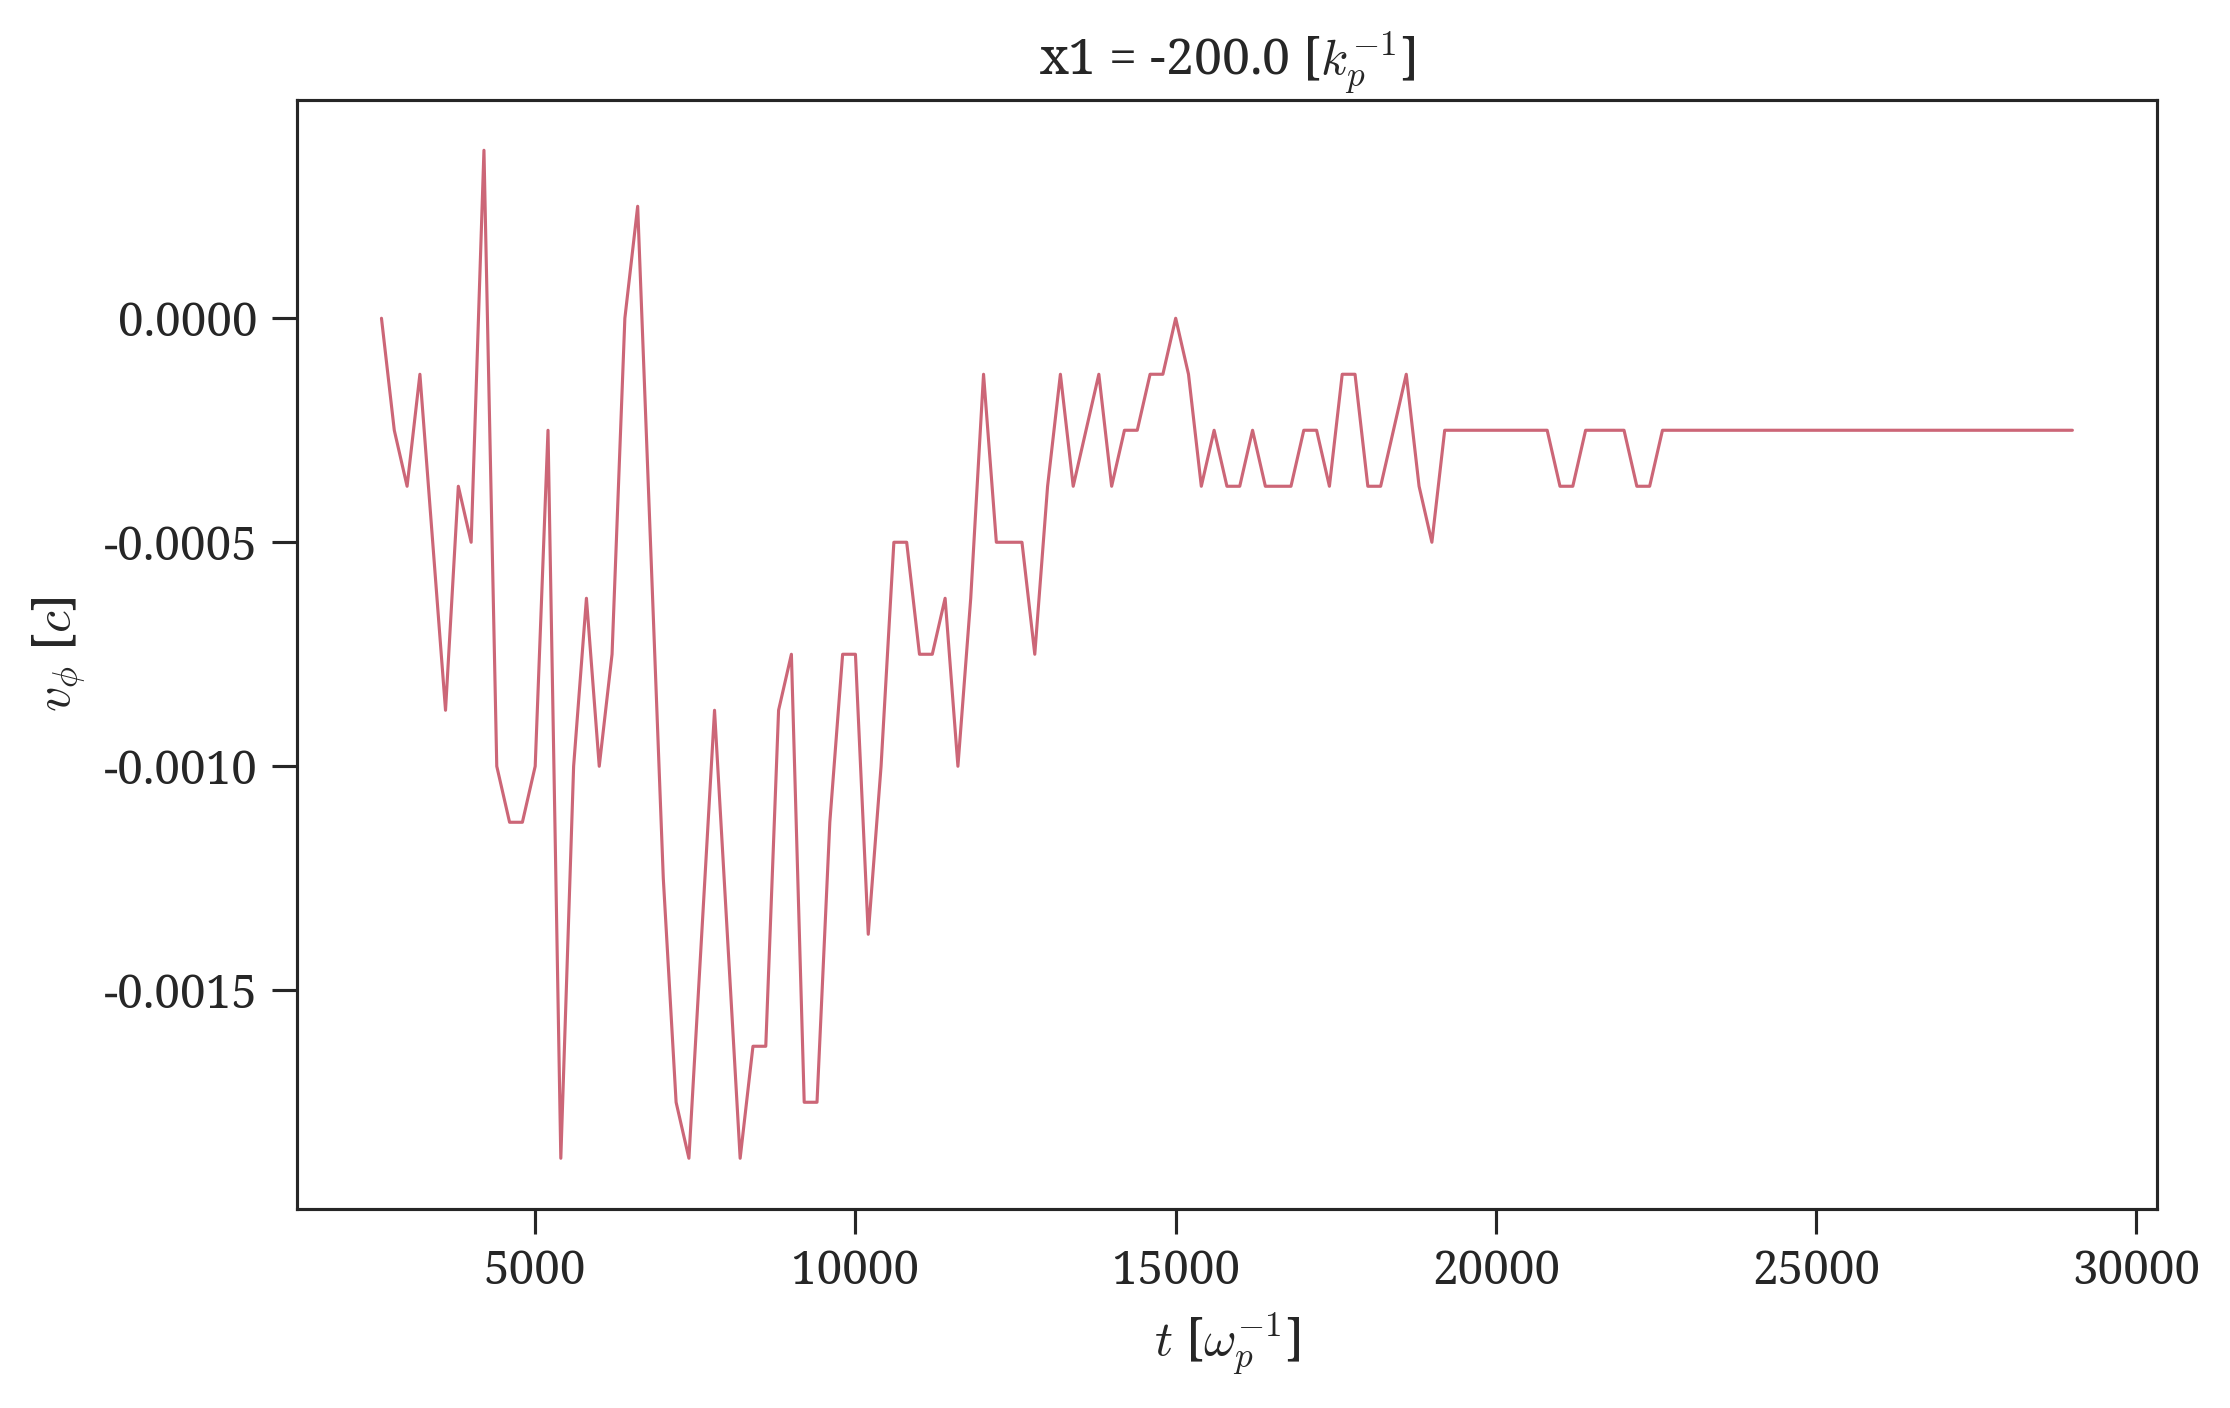

In [31]:
ds_vphi["vphi"].sel(x1=-200).plot()

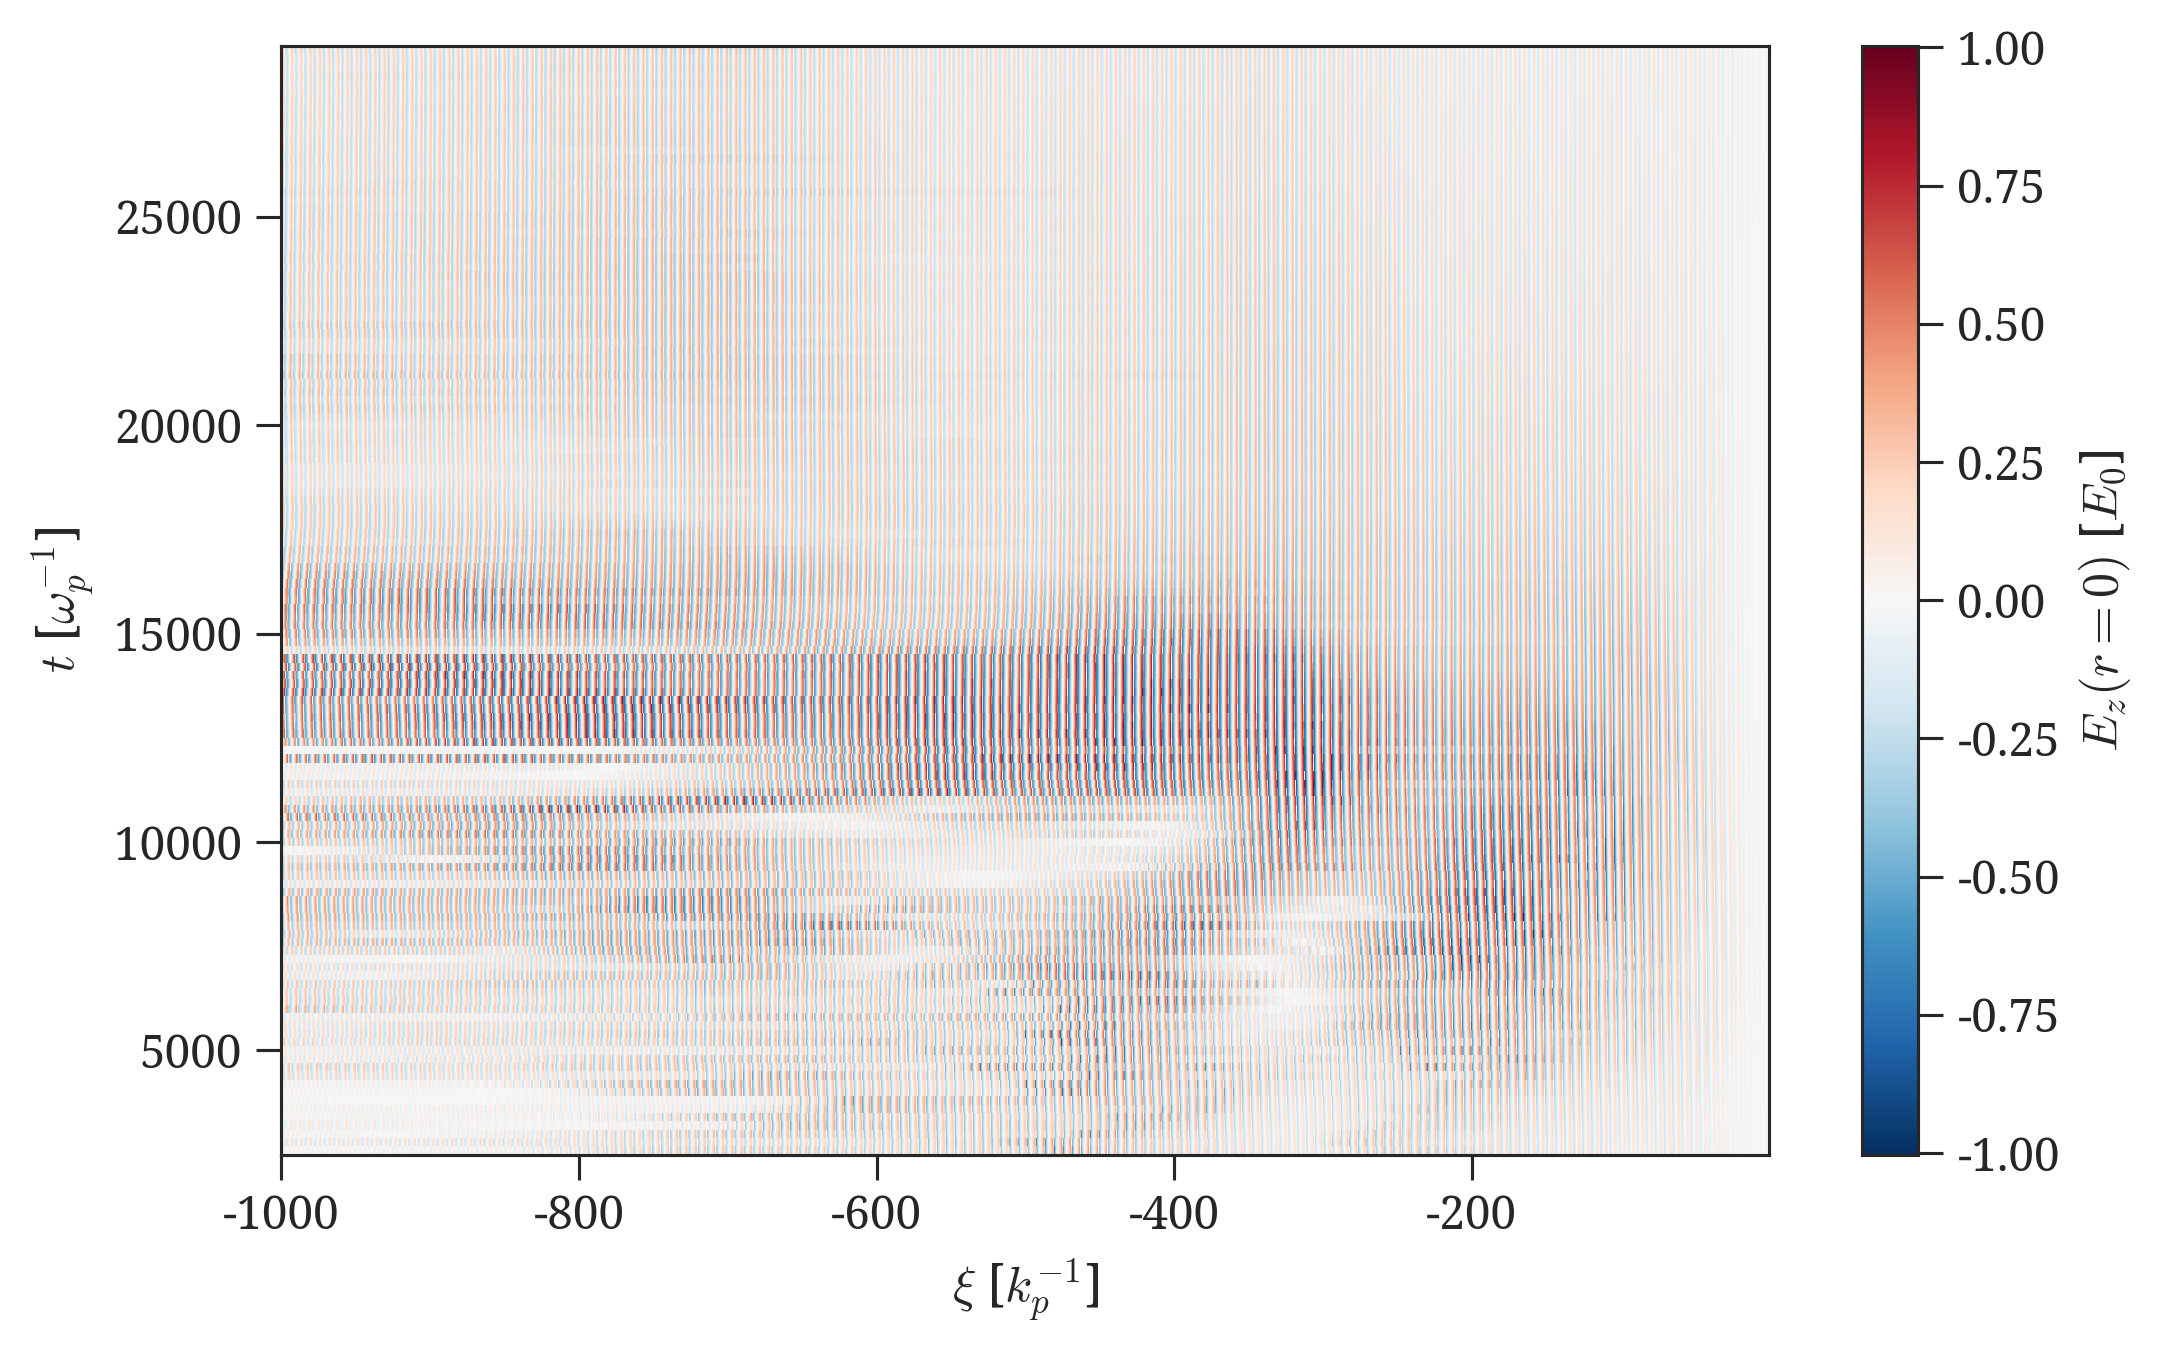

In [32]:
ds['xi_Ez'].plot()

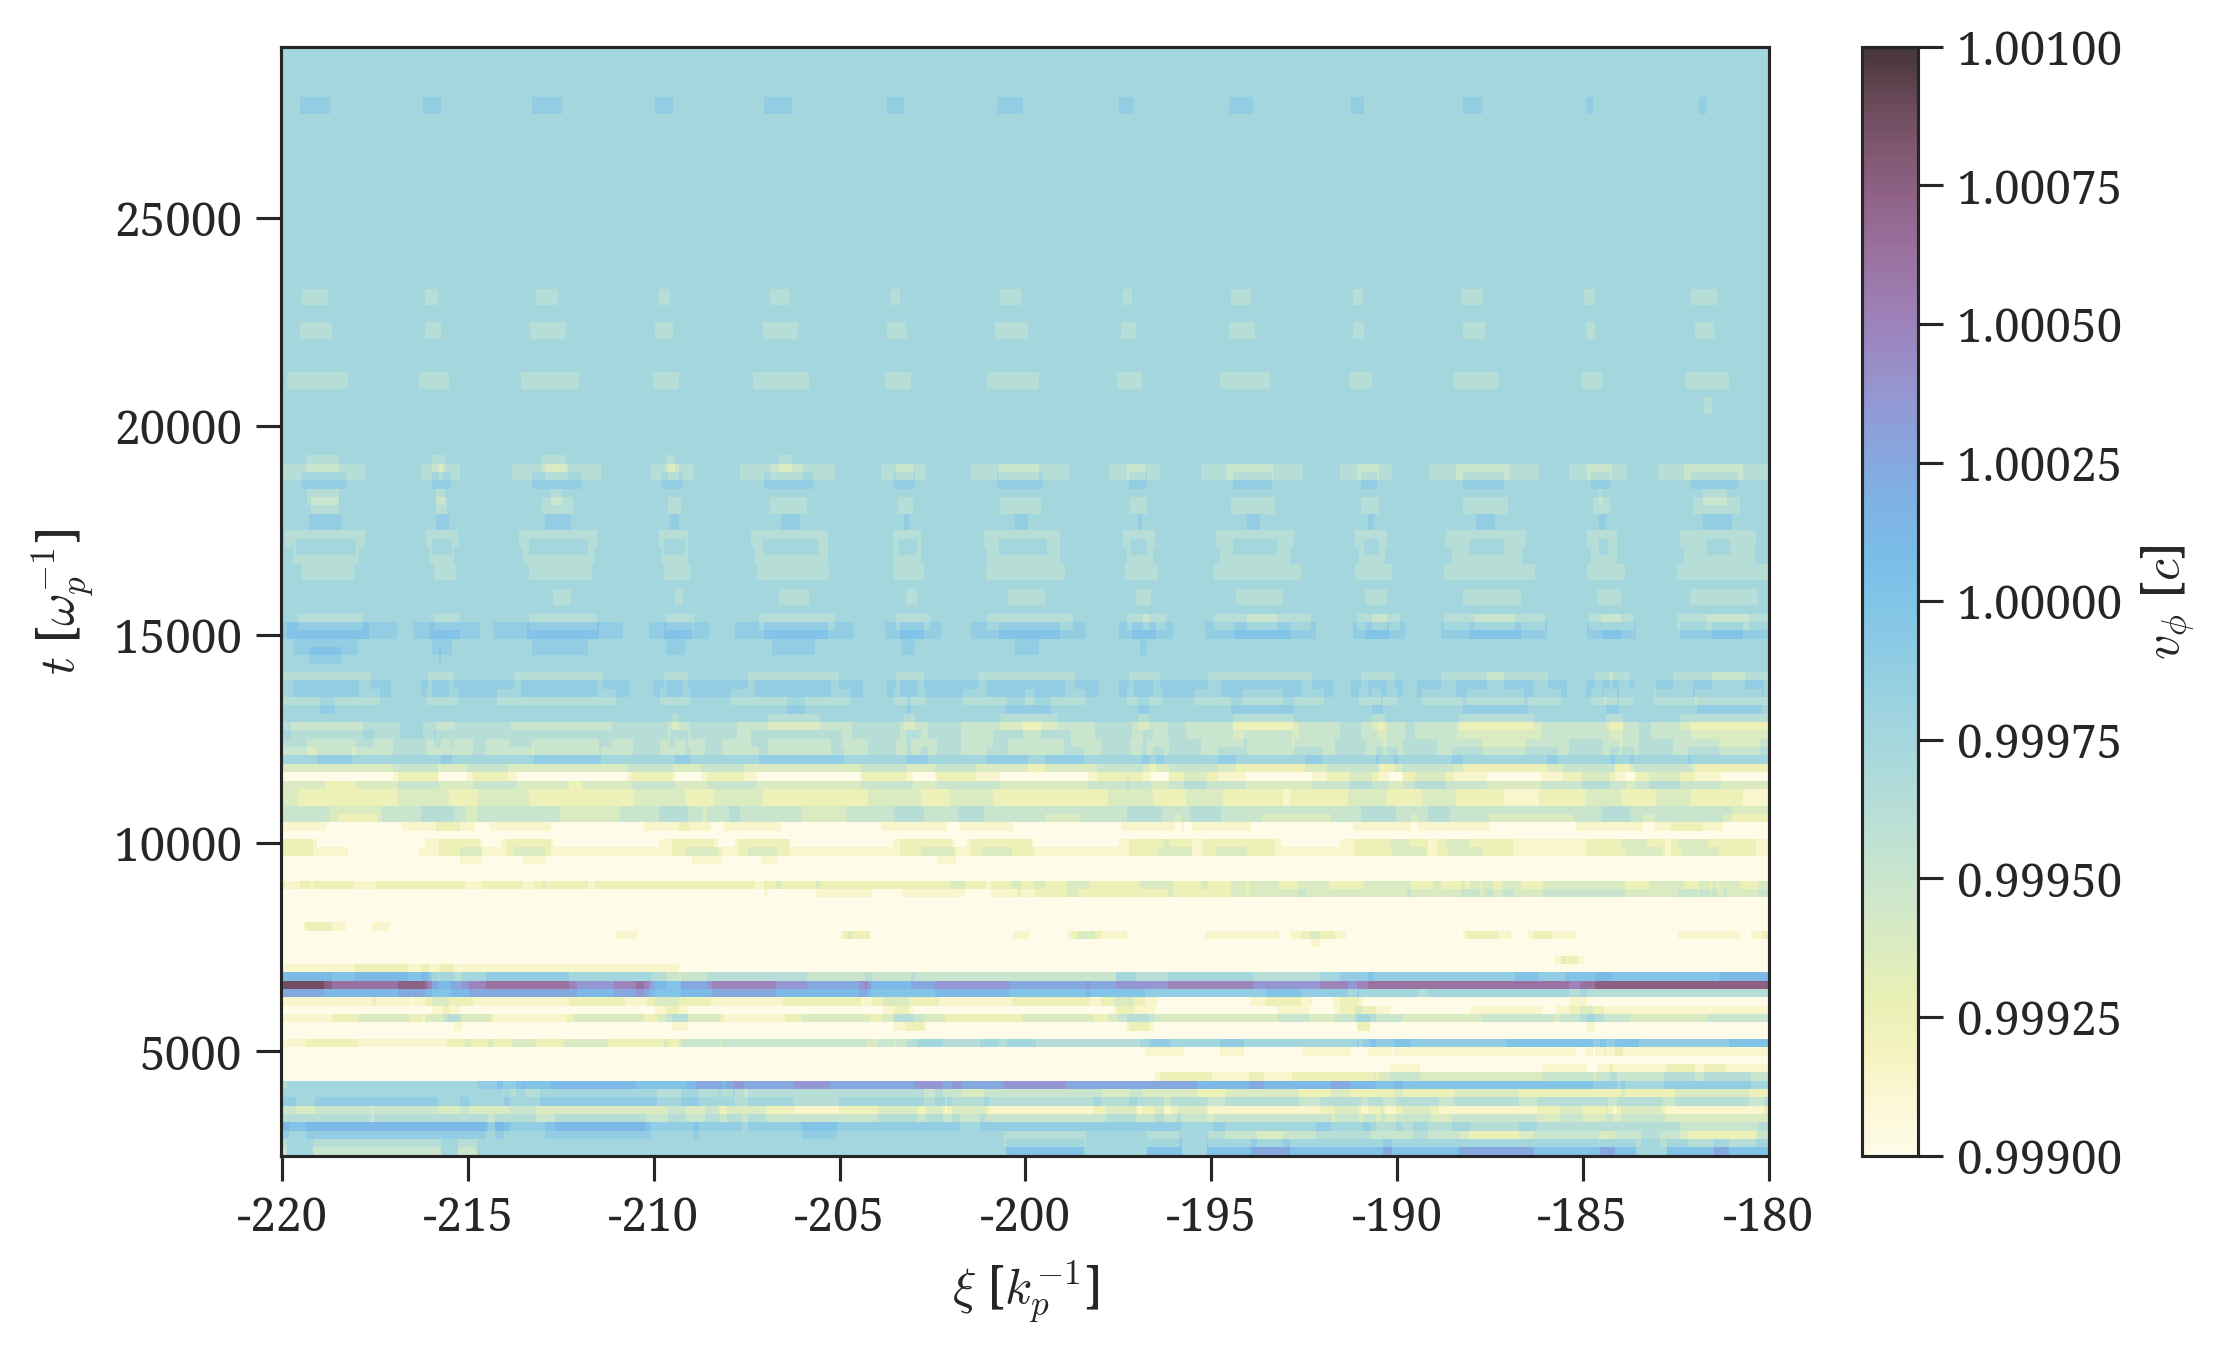

In [33]:
obj = (1.0+ds_vphi["vphi"]).sel(x1=slice(-220,-180)).plot()
obj.set_clim(0.999, 1.001)


## Older stuff

0.9996323529411765
0.00020424836601307117
0.0002626050420168058
105.08218152220232


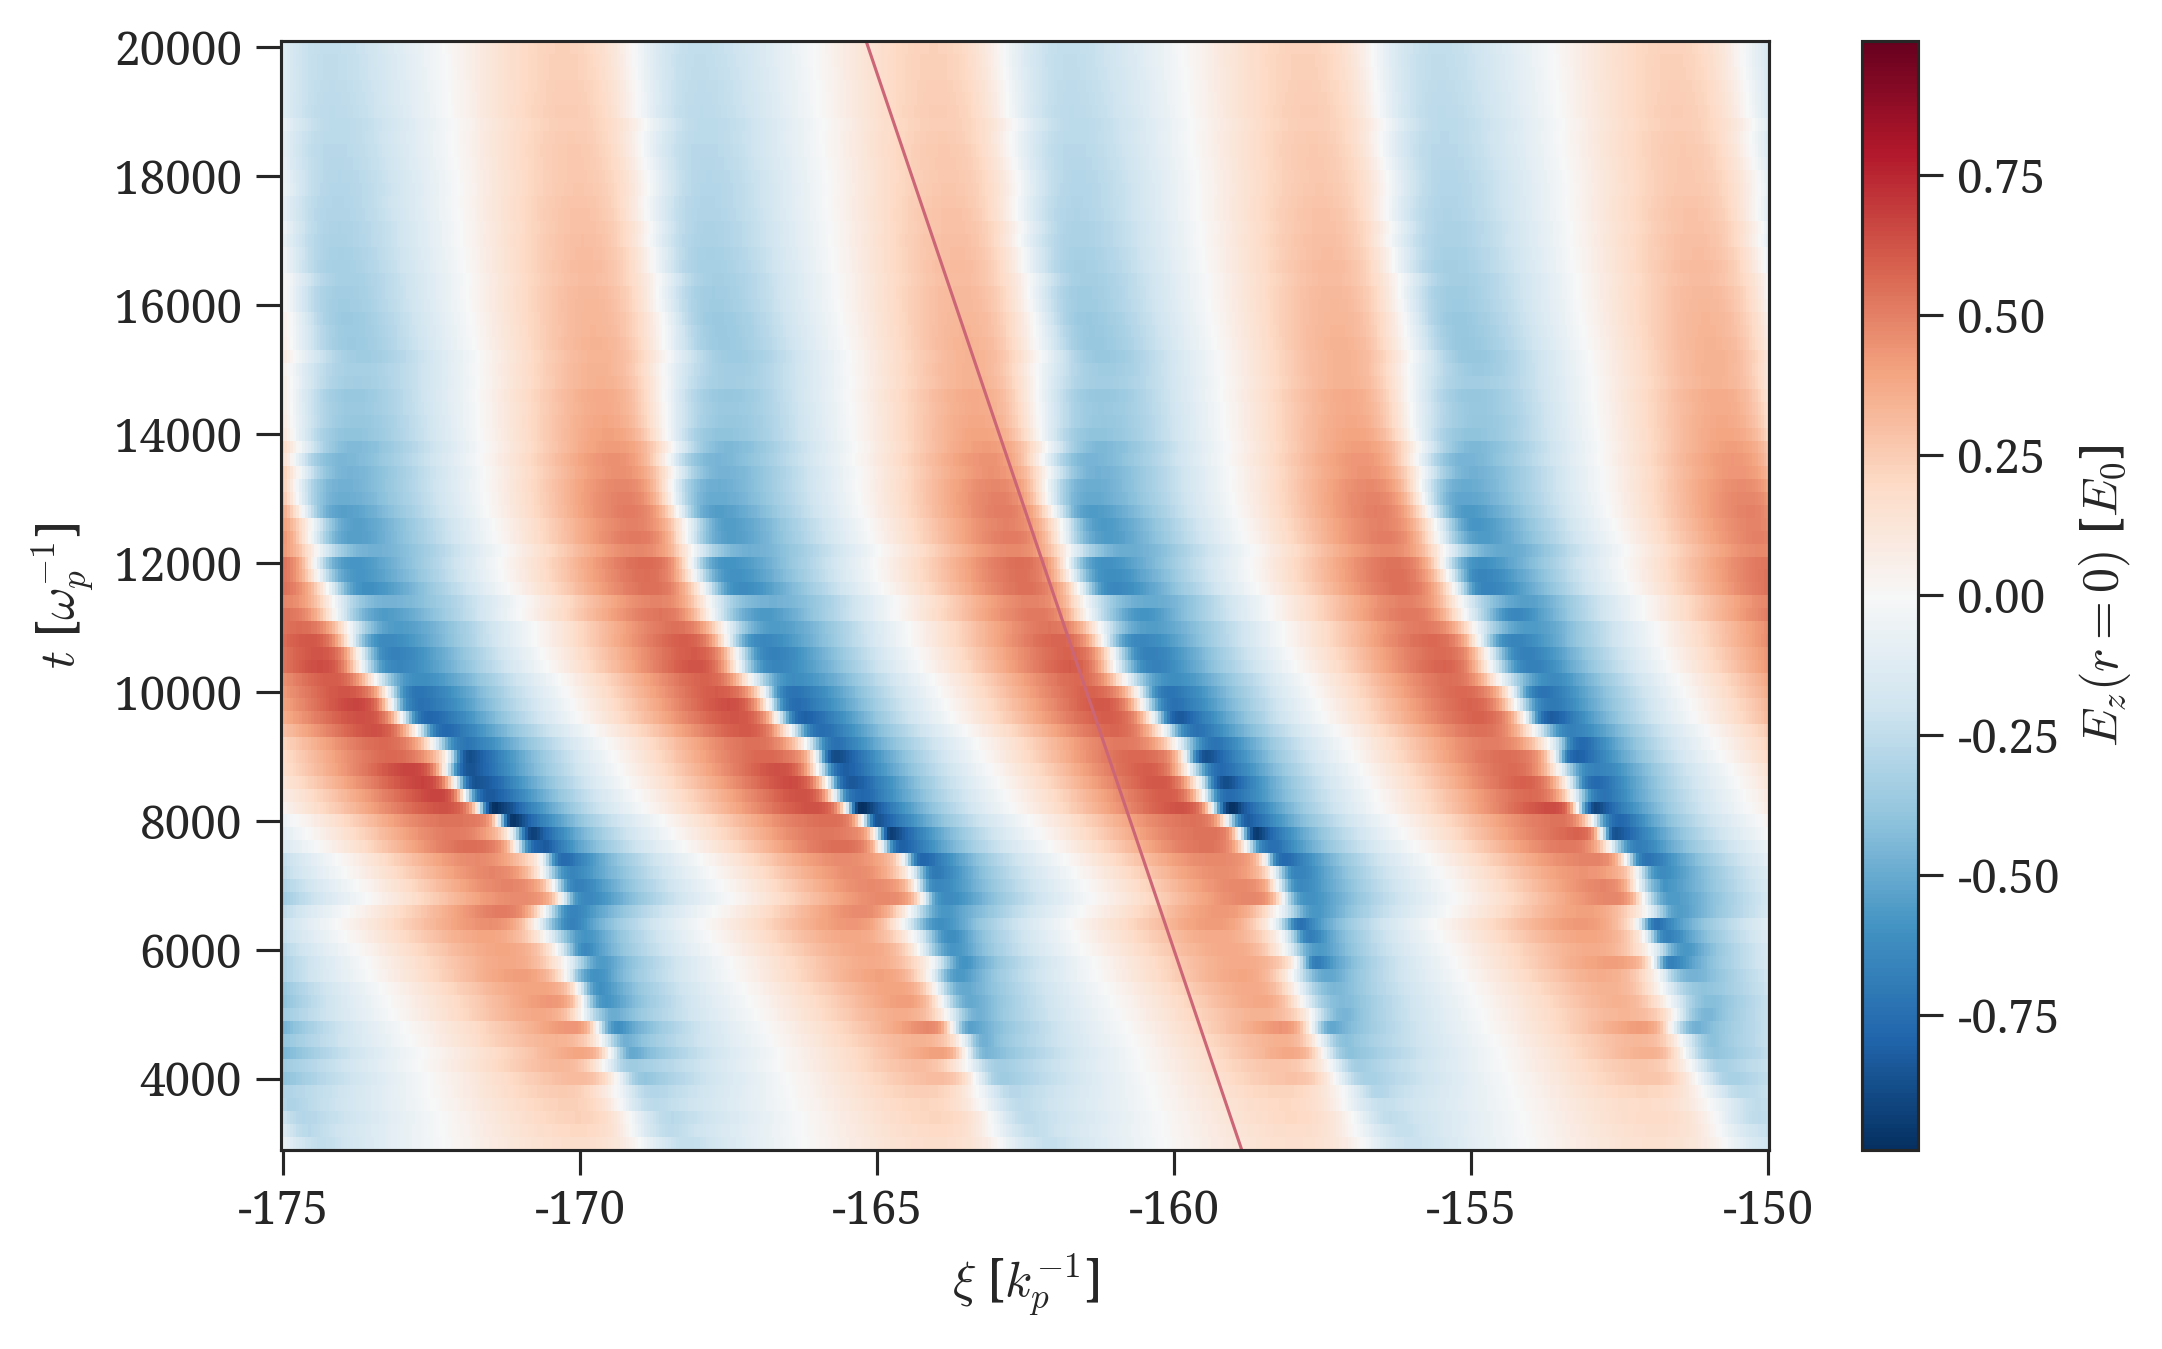

In [48]:
# obj = ds.plot()

ds_sample = ds.sel(x1 = slice(-175,-150), t = slice(3000,20000))
obj = ds_sample.plot()

res = flds.vphi_from_fft(ds_sample, ds_sample.x1.to_numpy(), ds_sample.t.to_numpy())
for item in res:
    print(item)

plt.plot(ds_sample.x1, 1/(res[0]-1)*(ds_sample.x1+160.0) + 6000)
plt.show()
# obj.set_clim(0.975, maxval)

In [19]:
res = flds.vphi_from_fft(ds_sample, ds_sample.x1.to_numpy(), ds_sample.t.to_numpy())
for item in res:
    print(item)

0.9991554054054054
0.00046921921921927456
0.0006032818532818451
70.26372762666075


(-200.0, 0.0)

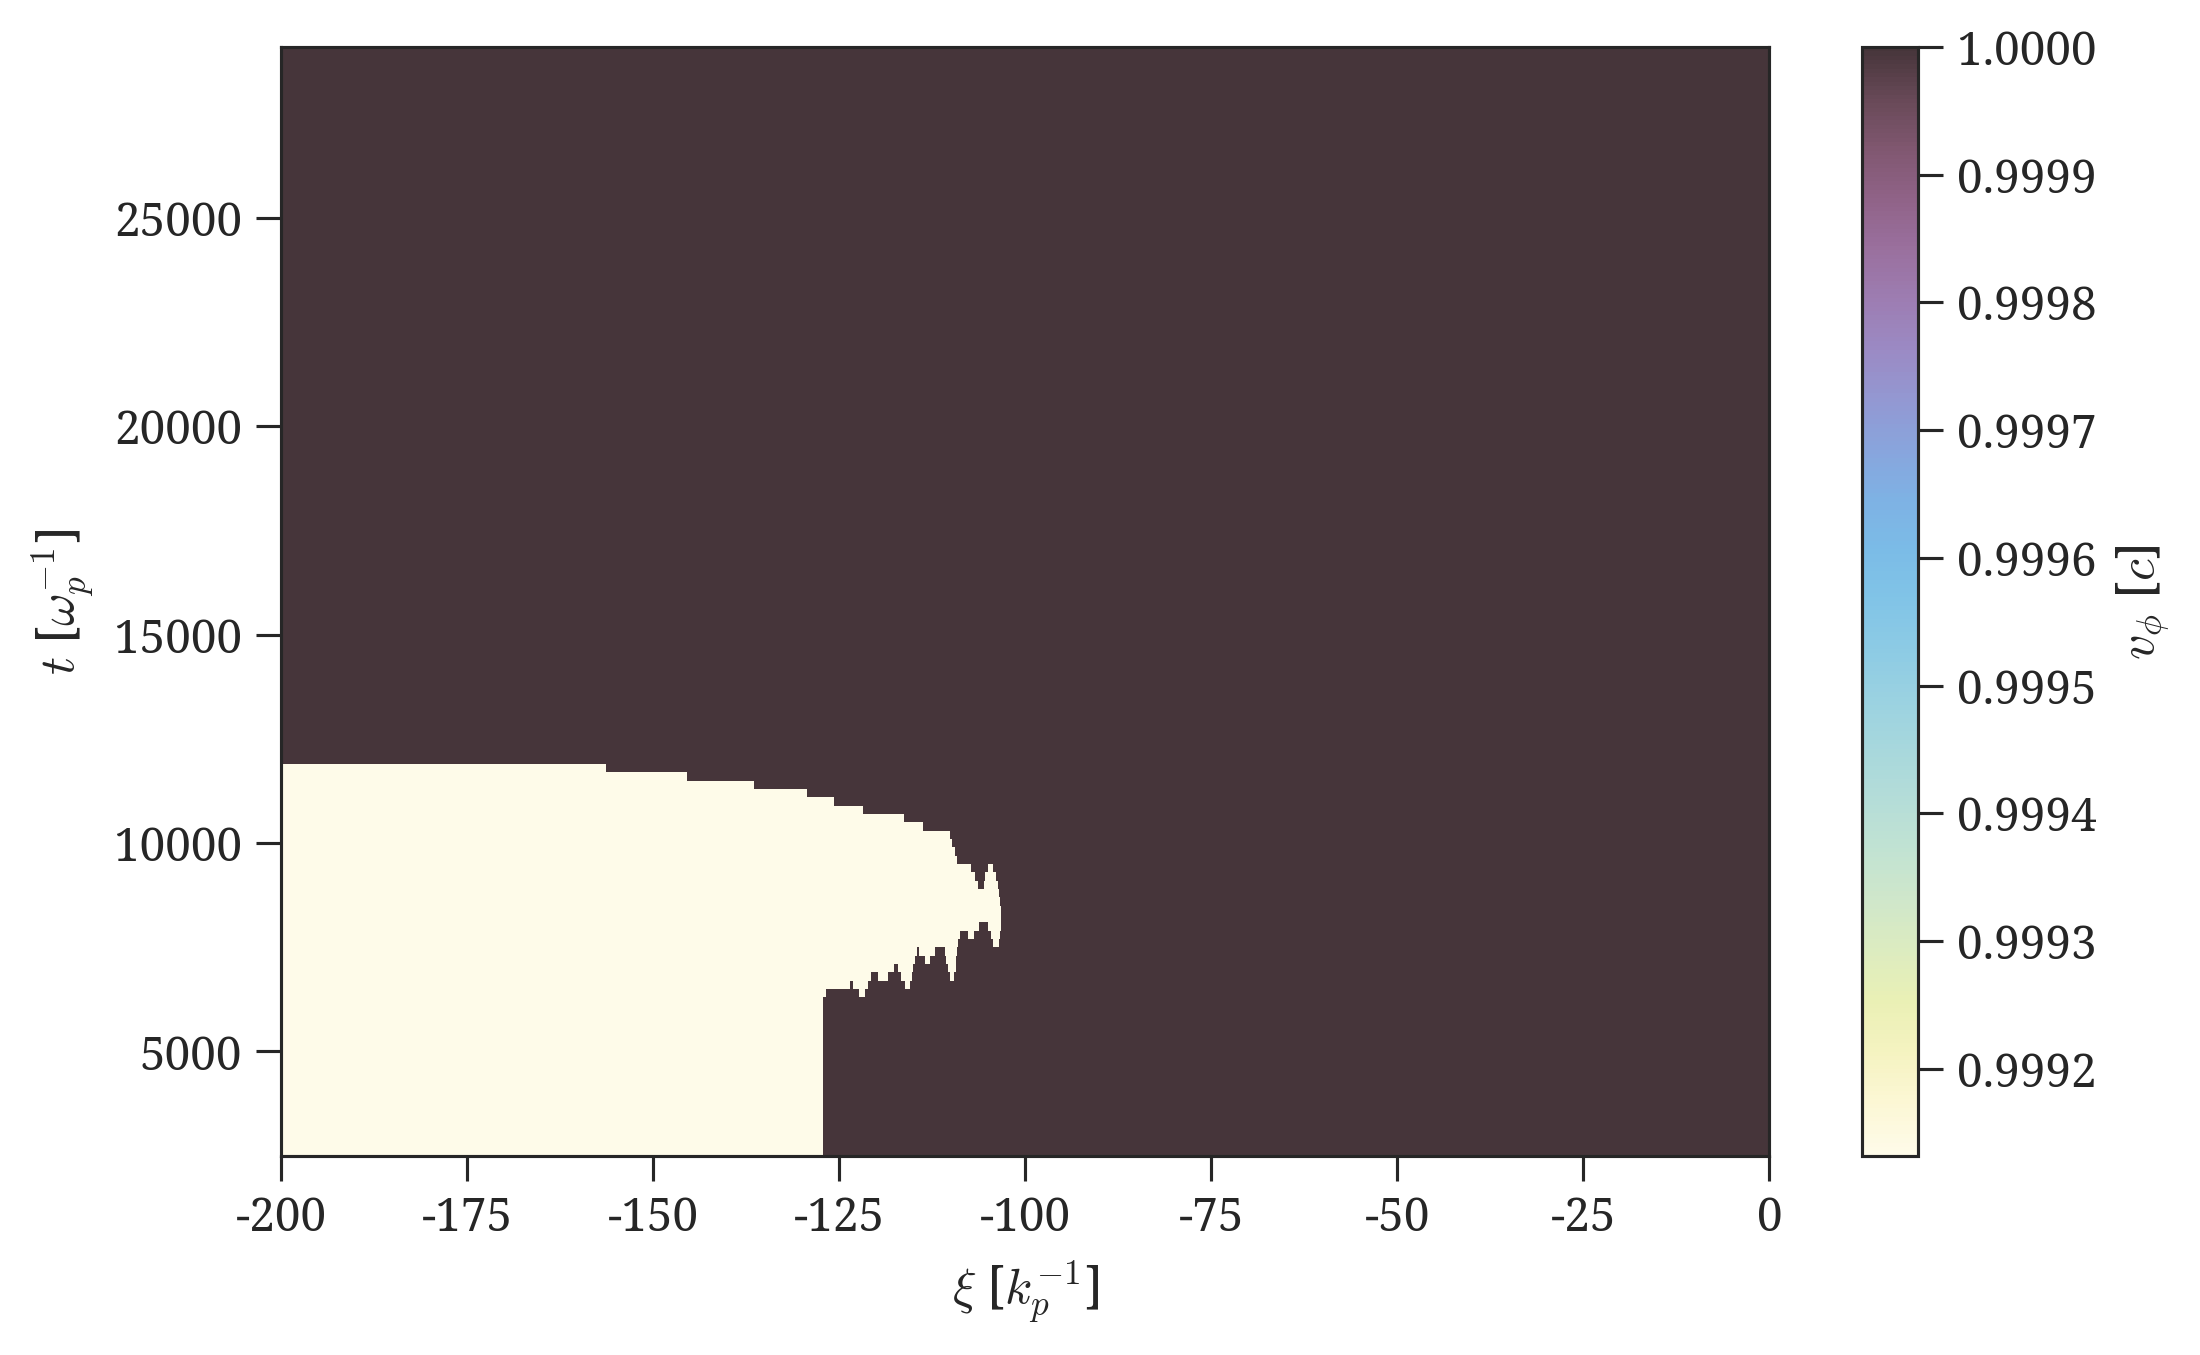

In [13]:
maxval = float(ds_v['vphi'].max().compute())

obj = ds_v['vphi'].plot()
# obj.set_clim(0.9999999, maxval)
plt.xlim((-200,0))

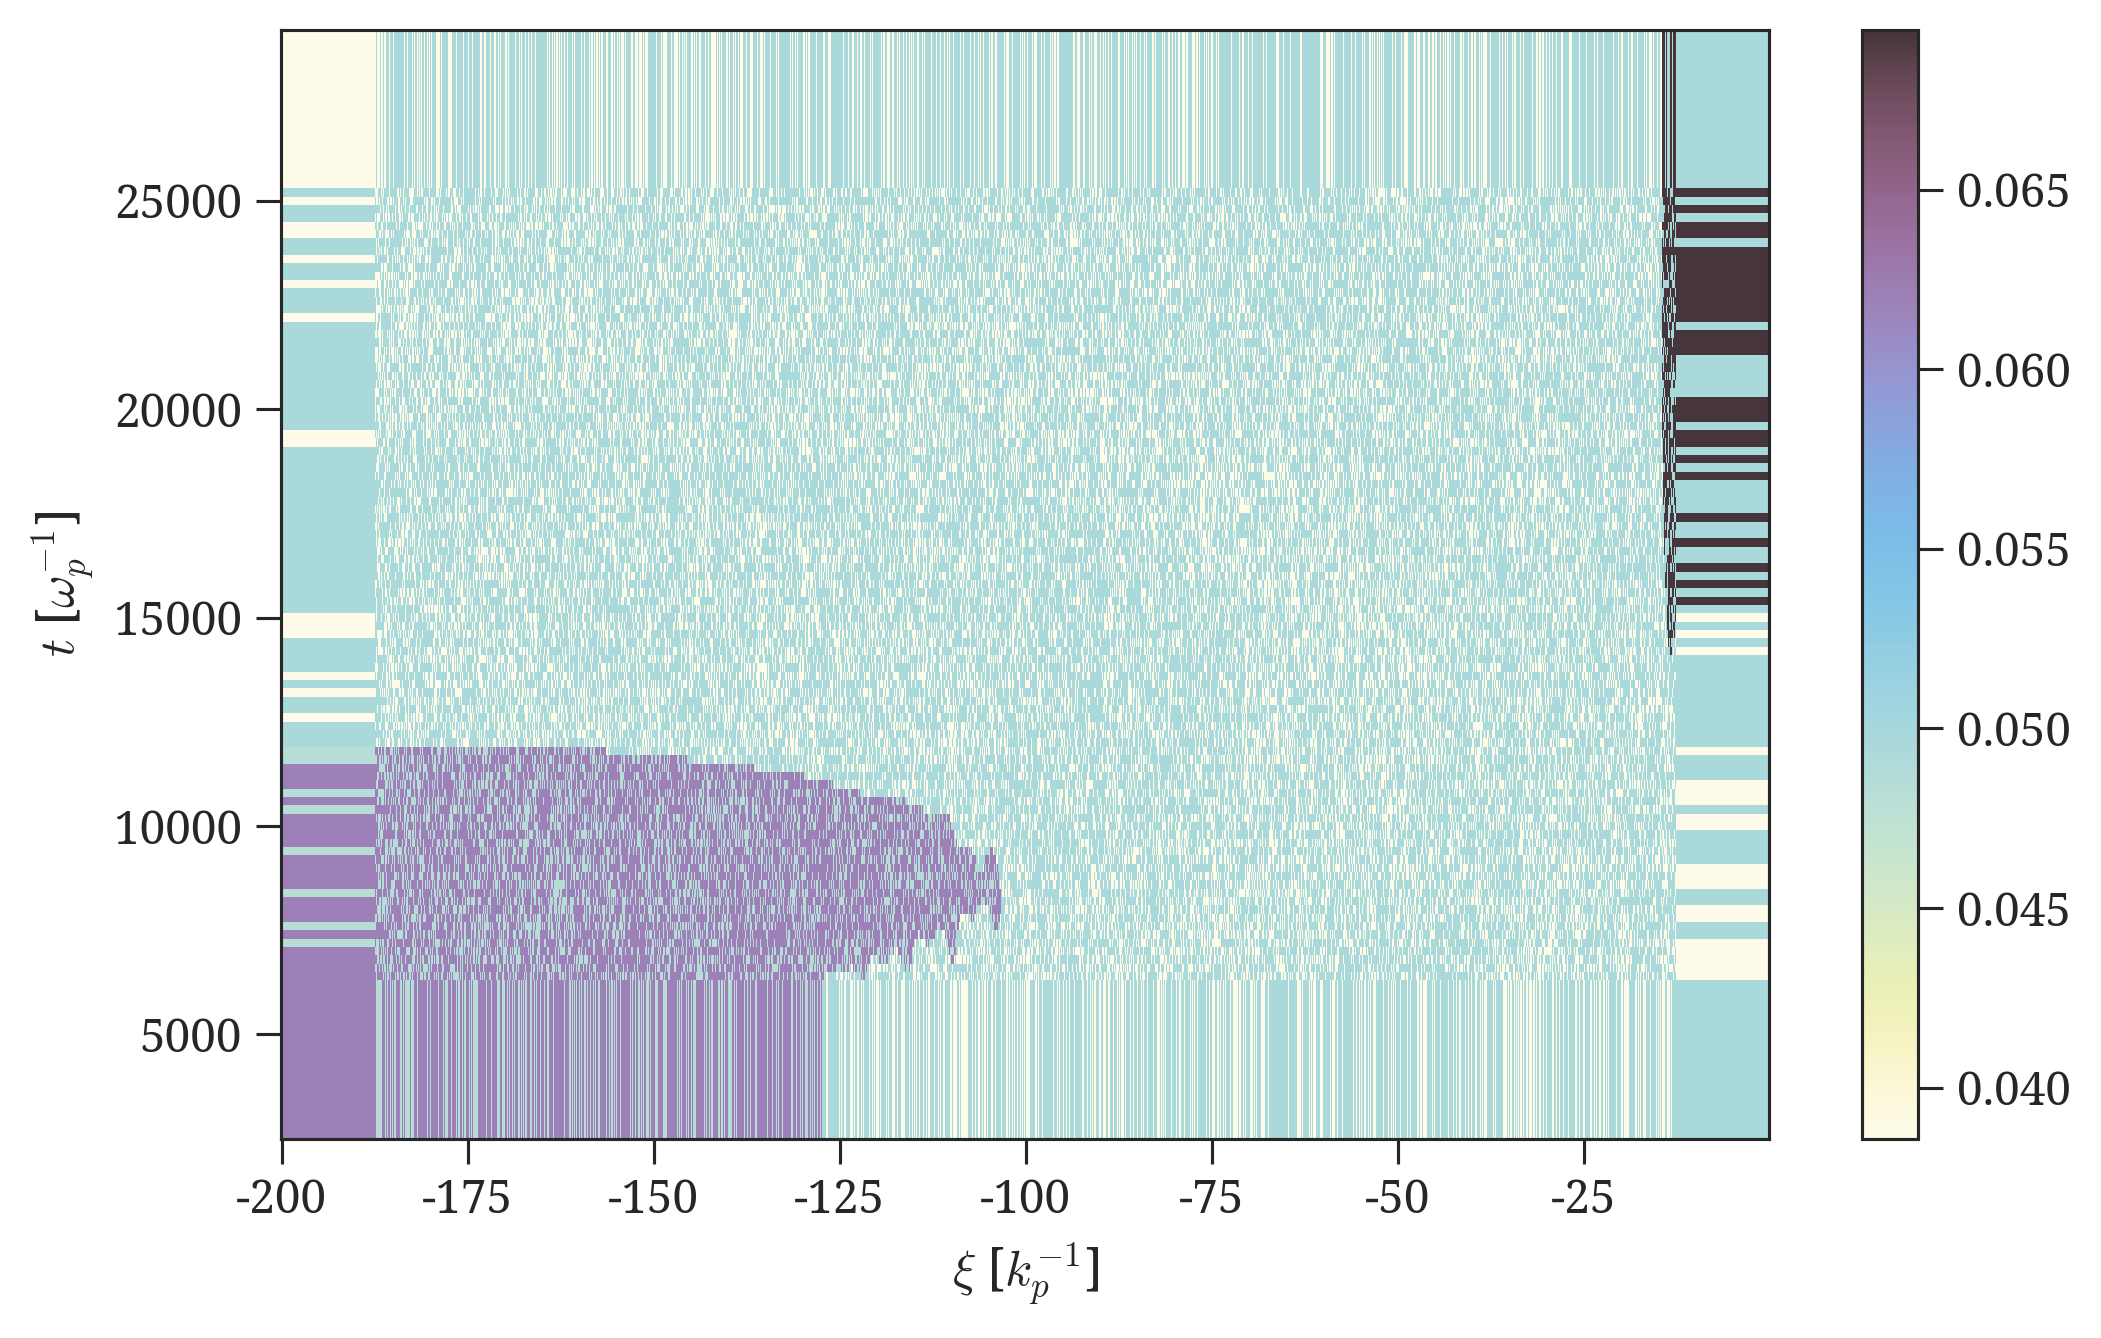

In [9]:
obj = (ds_v['vphi_err_pos']/ds_v['vphi']*100).plot()
# obj.set_clim(0.999, maxval)

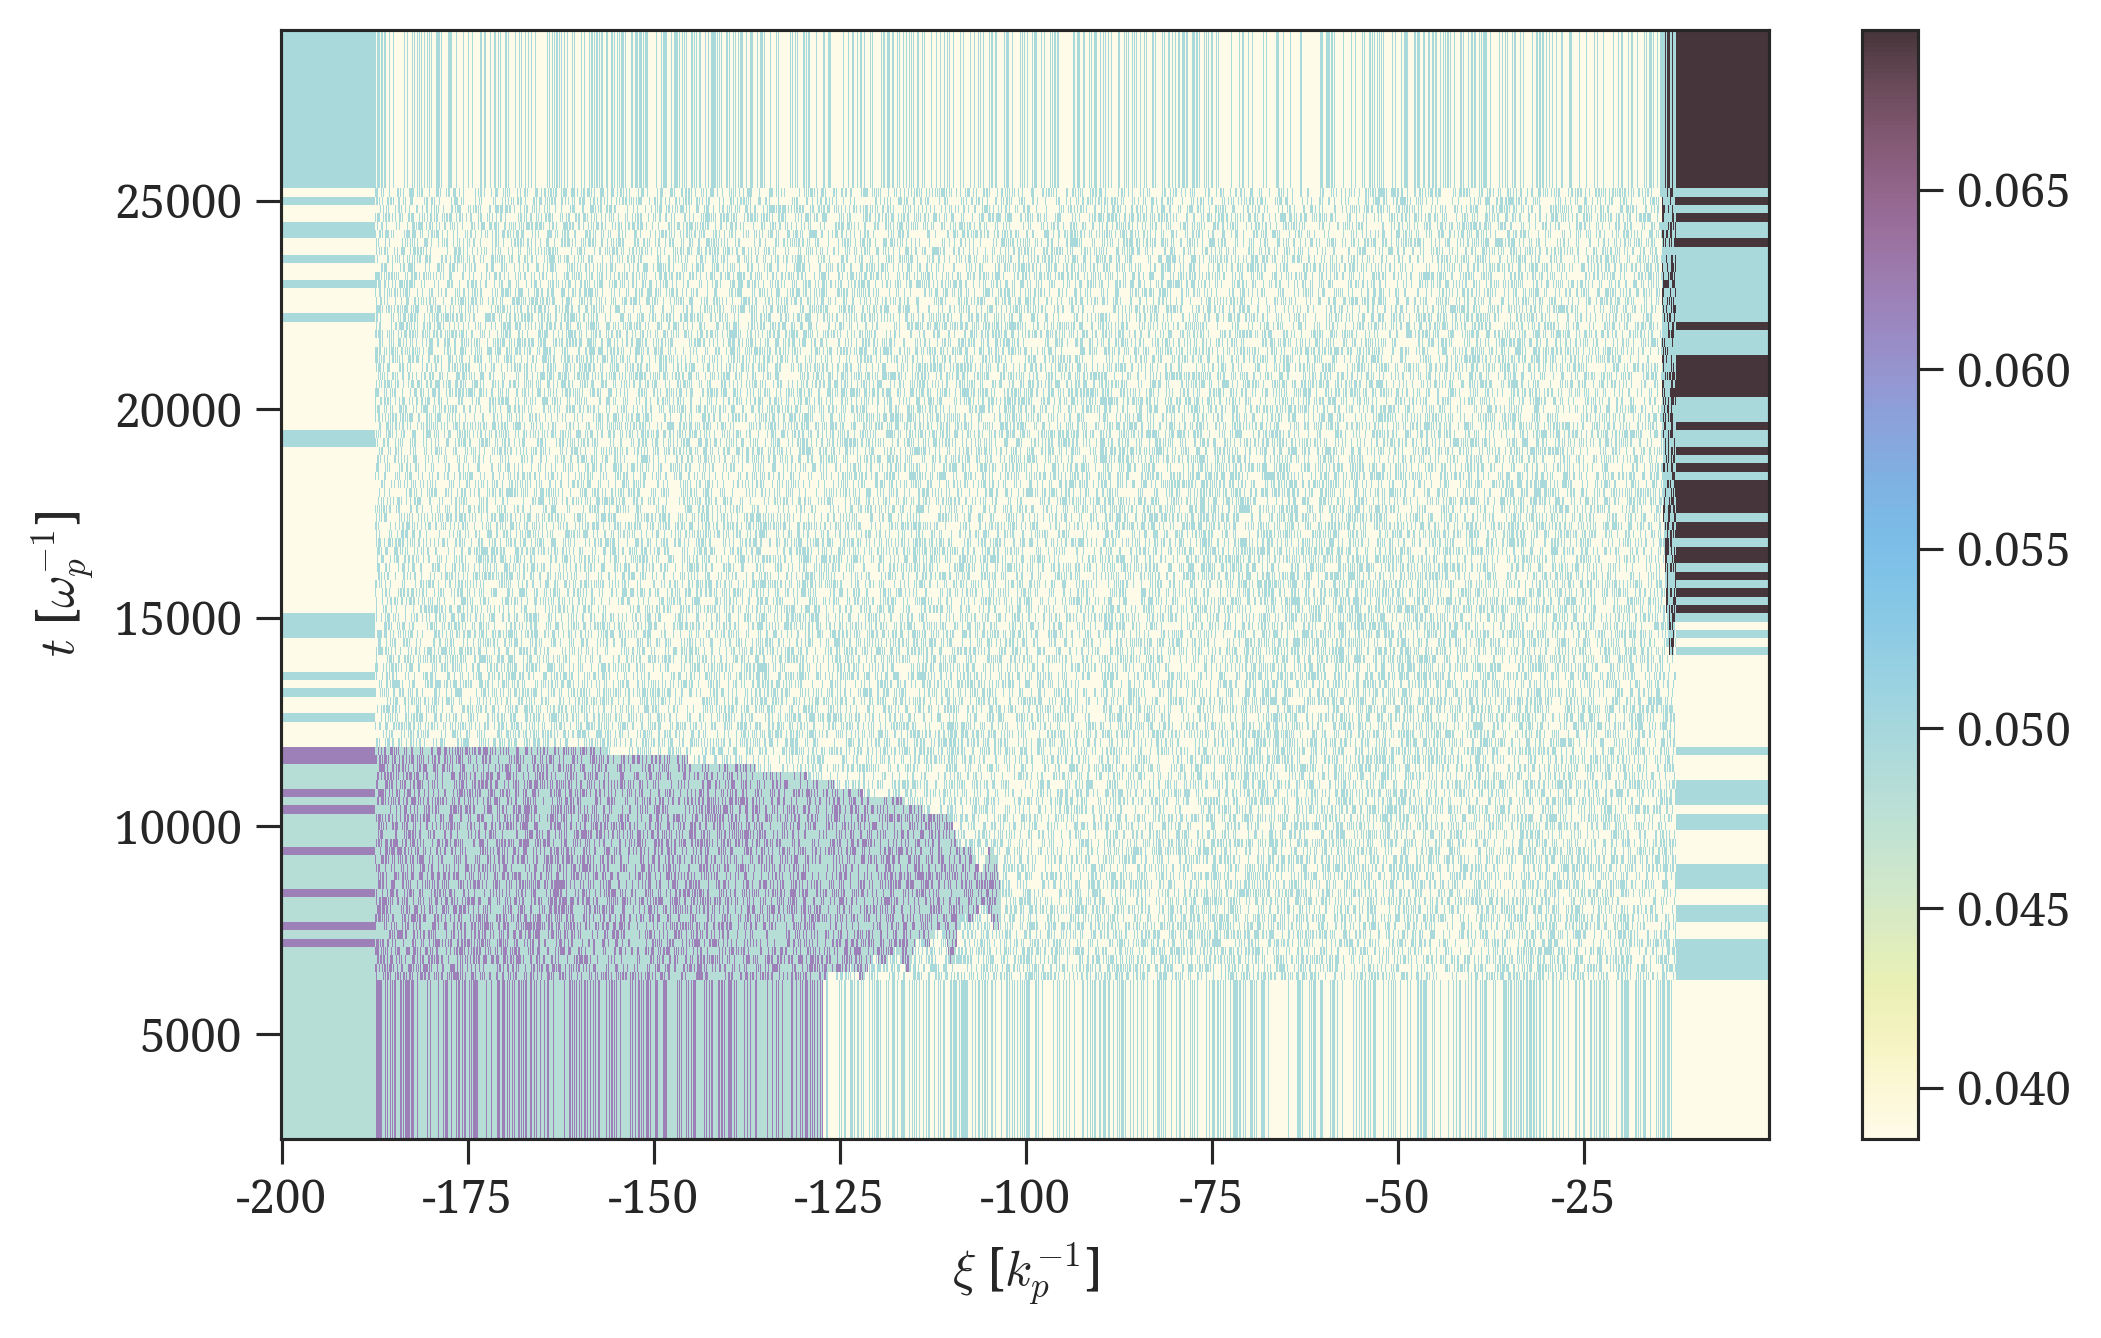

In [10]:
obj = (ds_v['vphi_err_neg']/ds_v['vphi']*100).plot()
# obj.set_clim(0.999, maxval)

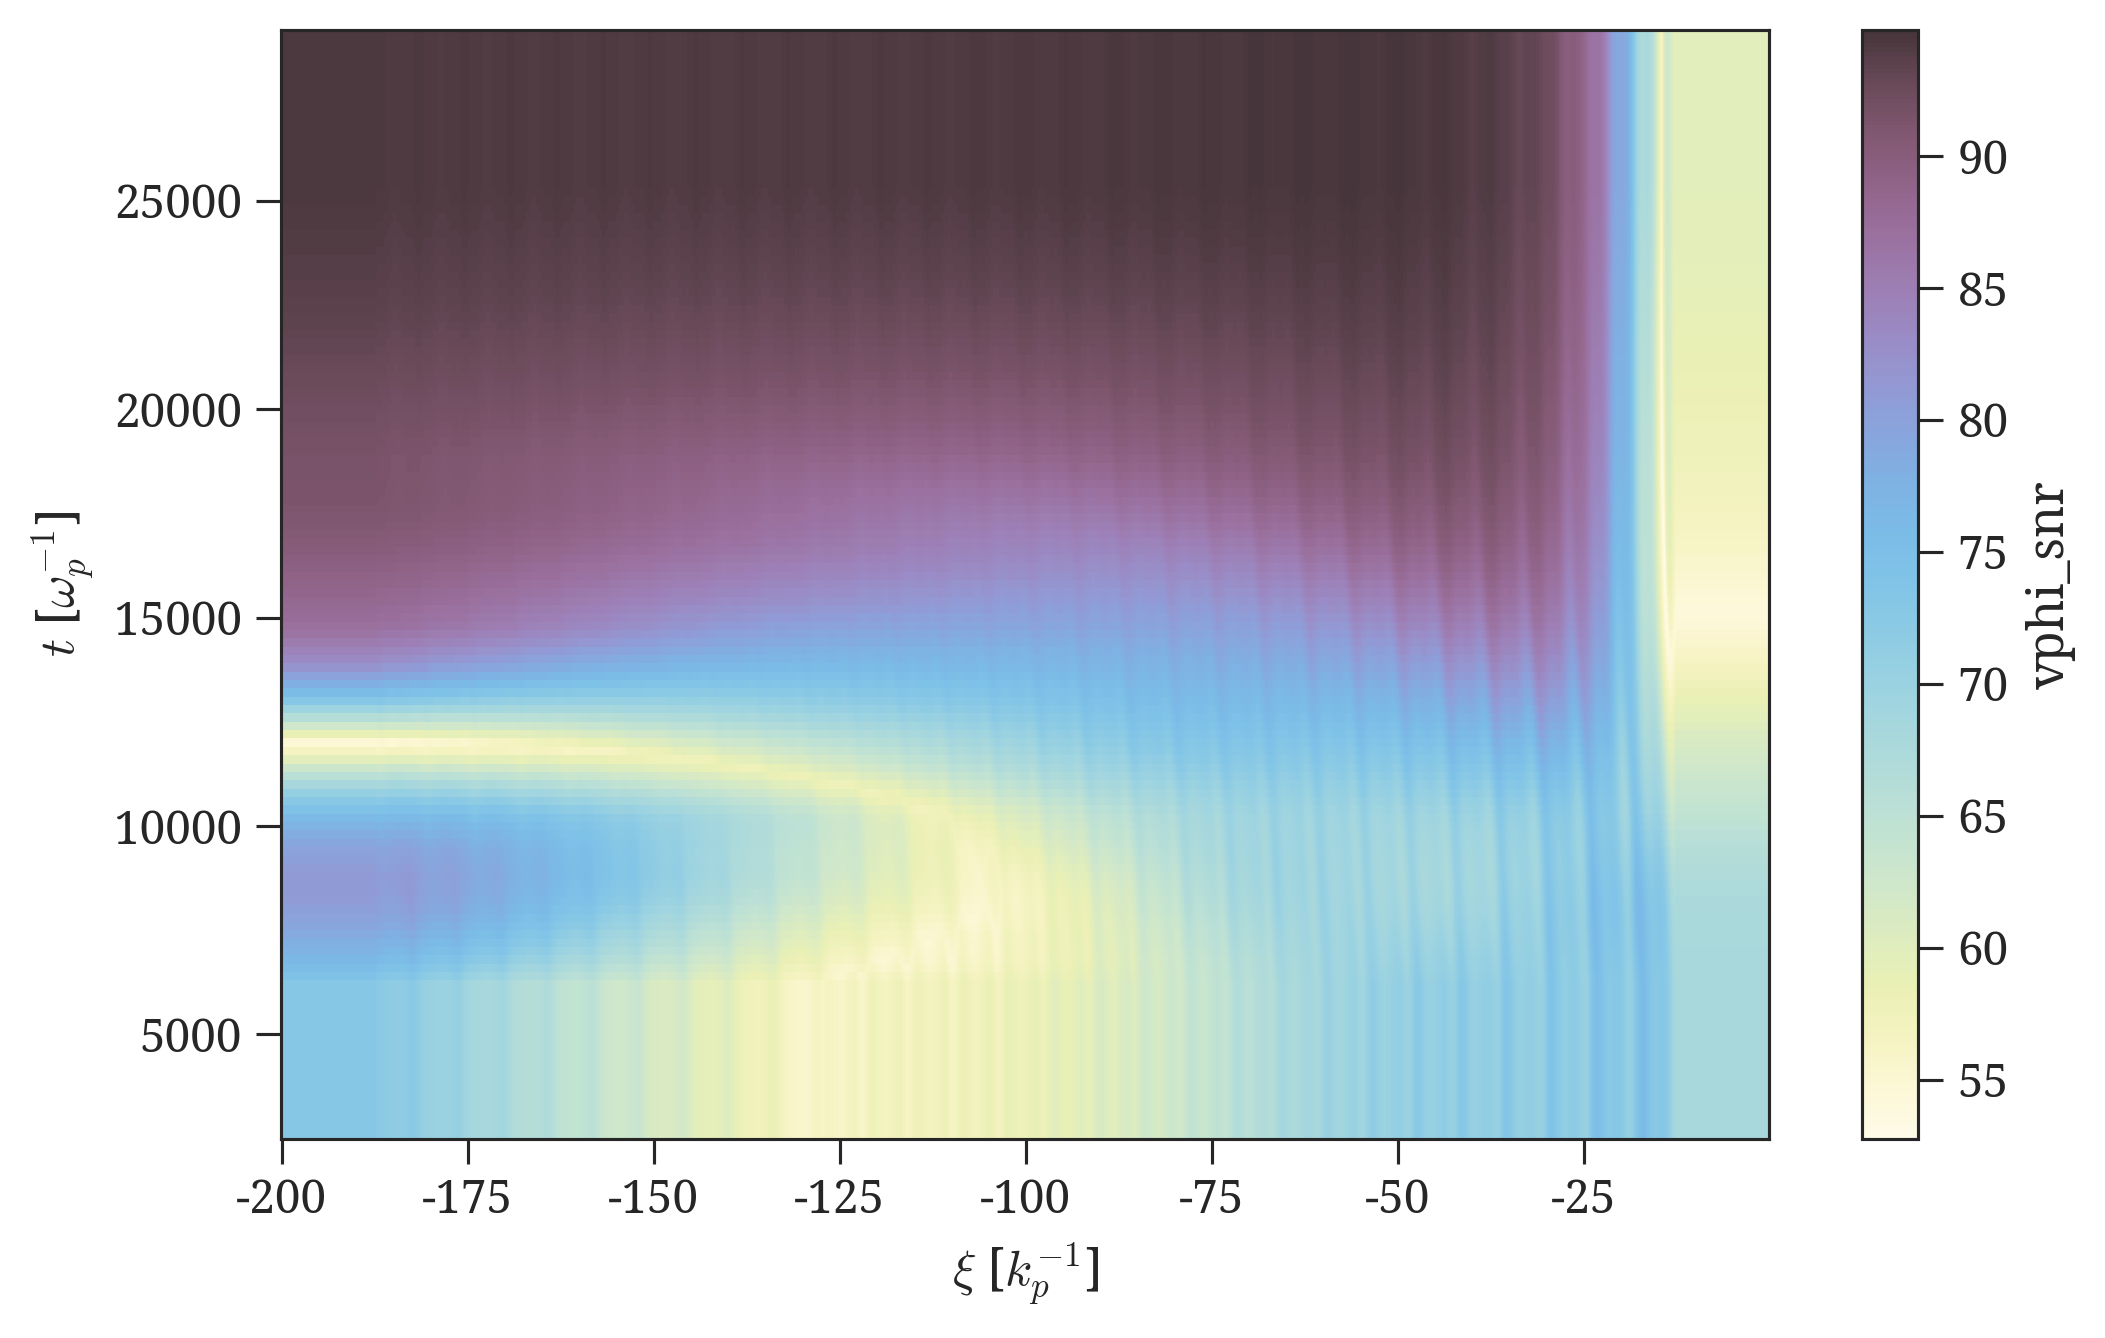

In [11]:
obj = ds_v['vphi_snr'].plot()

## Cross correlation

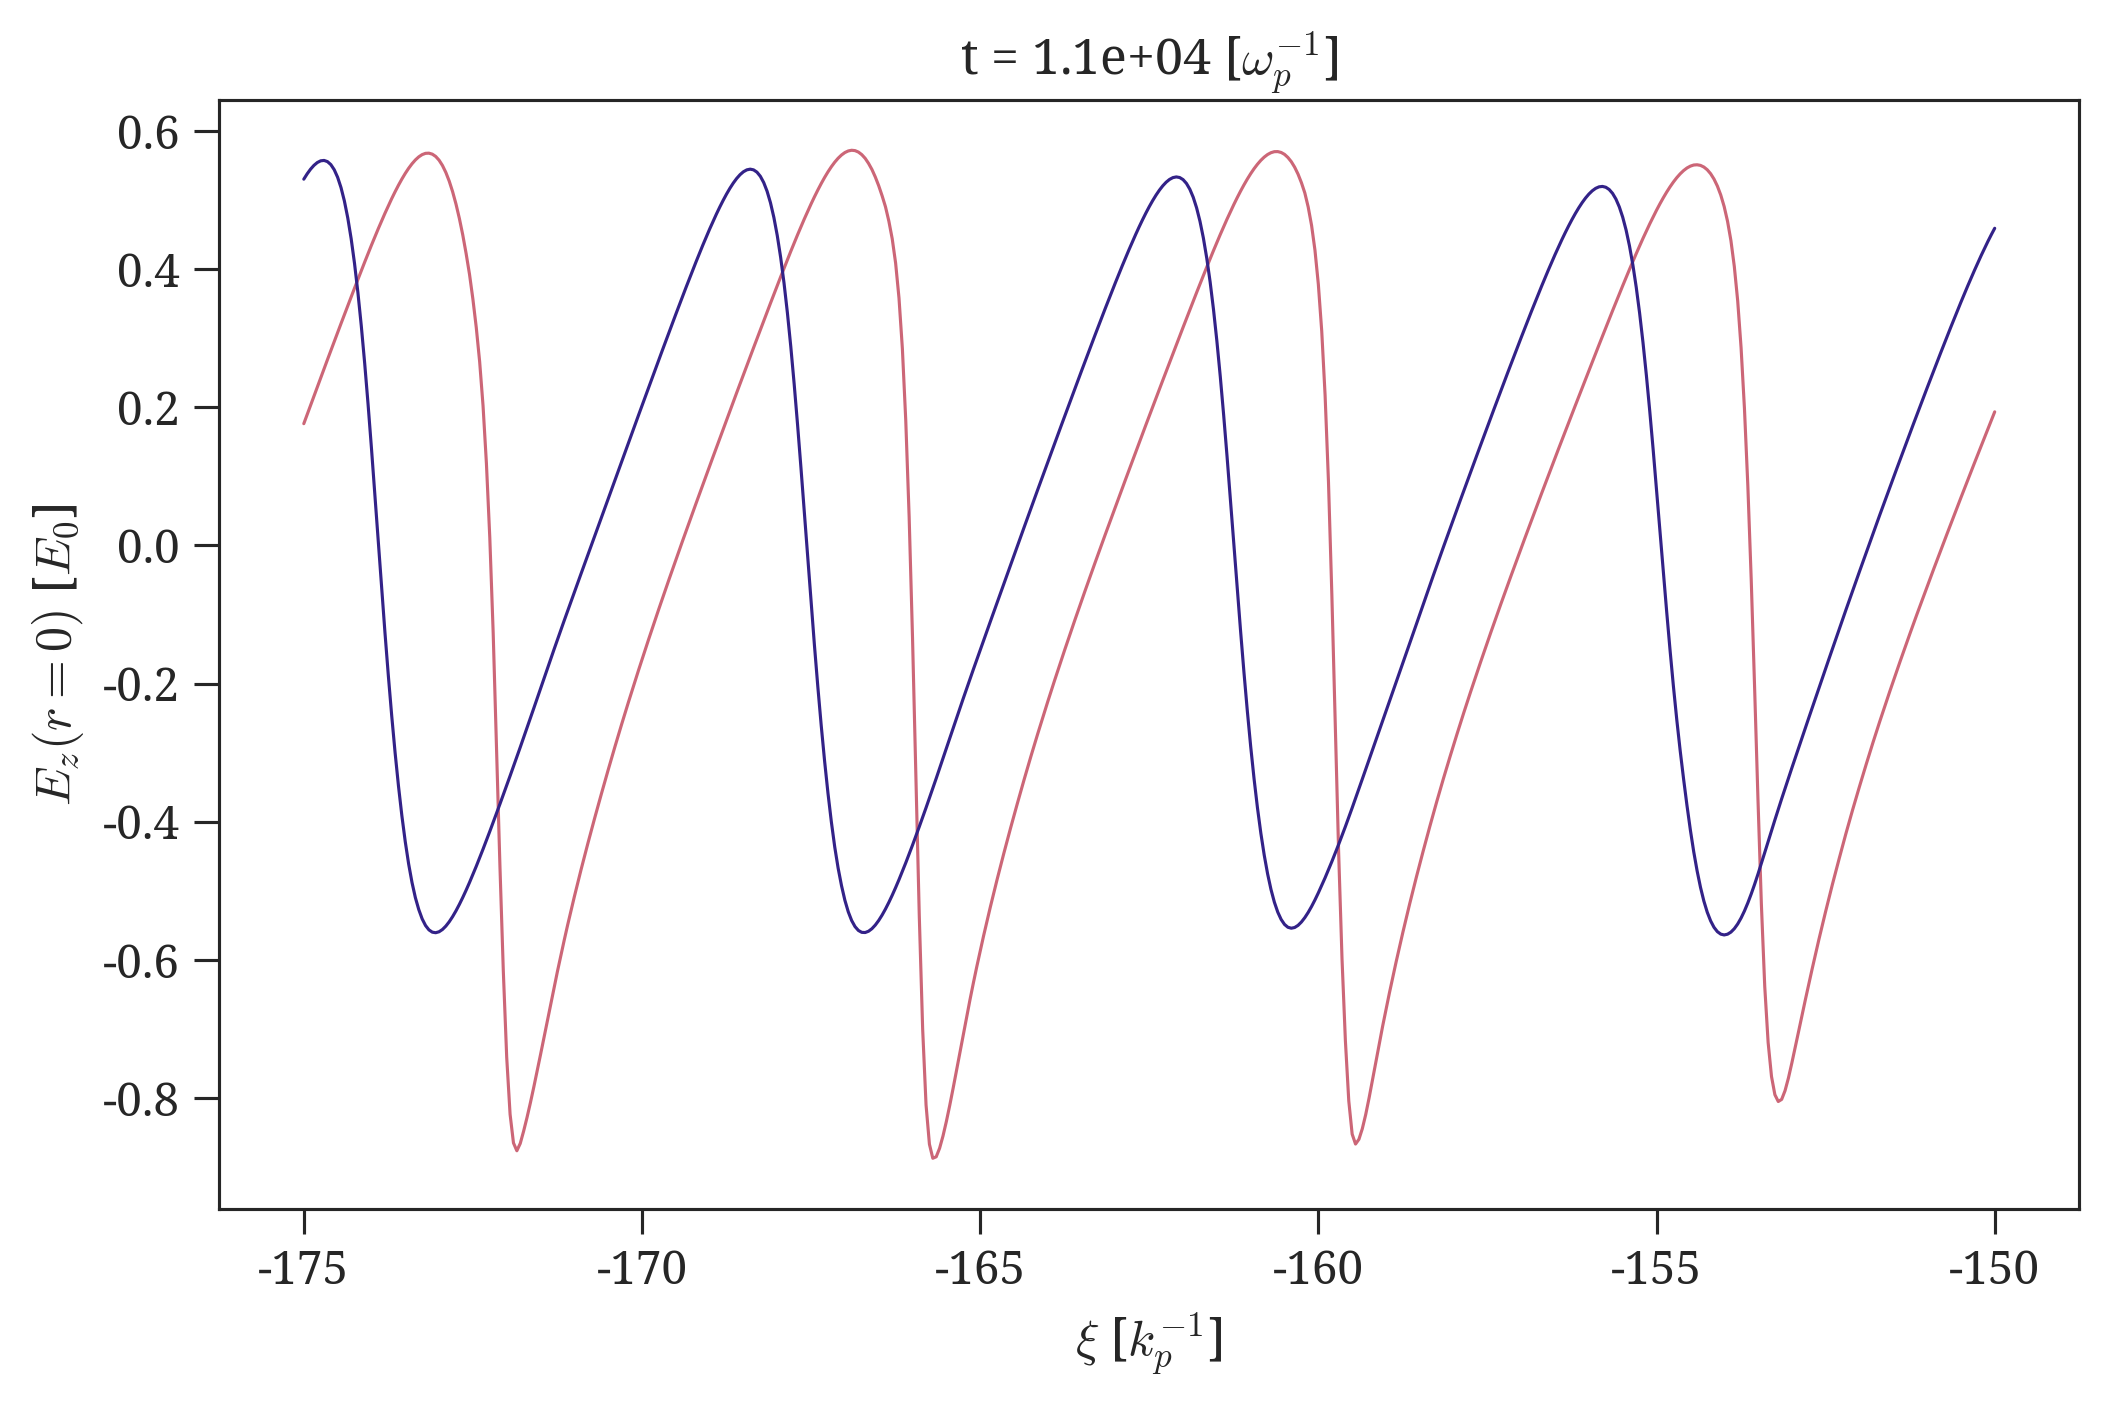

In [135]:
# obj = ds.plot()

ds_sample = ds.sel(x1 = slice(-175,-150), t = slice(3000,20000))

ds_sample.isel(t=30).plot()
ds_sample.isel(t=40).plot()
# ds_sample.isel(t=40).shift({'x1': int(1.3/0.05)}).plot()

In [73]:
ds_sample.dims

('t', 'x1')

In [142]:
np.min(ds_sample.x1).data

array(-175.)

In [185]:
def phase_from_xcorr(da1: xr.DataArray, da2: xr.DataArray, var: str = "x1"):

    corr_var = var + "_win"
    dx = da1.coords[var][1] - da1.coords[var][0]
    nx = da1.sizes[corr_var]
    ax_corr = np.linspace(-nx*dx, nx*dx, 2*nx+1)

    xcorr = xr.apply_ufunc(
        np.correlate,
        da1,
        da2,
        vectorize=True,
        kwargs=dict(mode="full"),
        dask="allowed",
        input_core_dims=[[corr_var], [corr_var]],
        exclude_dims={corr_var},
        output_core_dims=[[corr_var]],
        output_dtypes=[float],
    )

    # TODO: check that both axes of da1 and da2 are the same

    # axmin = np.min(da1.coords[var]).data
    # axis = da1.coords[var].to_numpy() - axmin

    # ax_corr = np.concatenate((np.flip(-axis[1:]), axis))
    xcorr = xcorr.assign_coords({corr_var: ax_corr})

    dshift = max(xcorr)[corr_var].data

    return dshift

In [188]:
def func_phase(da):
    return phase_from_xcorr(da.isel(t_win=1), da.isel(t_win=0), var='x1')


rolling = ds_sample.rolling(t=2, x1=201, center={'x1': True, 't': False})
ds_roll = rolling.construct(t='t_win', x1='x1_win')
display(ds_roll)
ds_stack = ds_roll.stack(gridcell=['t','x1'])
display(ds_stack)
# display(ds_stack.sel(t=3000, x1=-150))
ds_group = ds_stack.groupby('gridcell')
print(ds_group)
newArray = ds_group.map(func_phase)
ds['newArray'] = newArray.unstack('gridcell')


<xarray.DataArray 'xi_Ez' (t: 86, x1: 501, t_win: 2, x1_win: 201)>
dask.array<sliding_window_view, shape=(86, 501, 2, 201), dtype=float64, chunksize=(86, 500, 2, 201), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) float64 3e+03 3.2e+03 3.4e+03 ... 1.96e+04 1.98e+04 2e+04
  * x1       (x1) float64 -175.0 -174.9 -174.9 -174.8 ... -150.1 -150.1 -150.0
Dimensions without coordinates: t_win, x1_win
Attributes:
    long_name:  $E_z(r=0)$
    units:      $E_0$

<xarray.DataArray 'xi_Ez' (t_win: 2, x1_win: 201, gridcell: 43086)>
dask.array<reshape, shape=(2, 201, 43086), dtype=float64, chunksize=(2, 201, 21543), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) object MultiIndex
  * t         (gridcell) float64 3e+03 3e+03 3e+03 3e+03 ... 2e+04 2e+04 2e+04
  * x1        (gridcell) float64 -175.0 -174.9 -174.9 ... -150.1 -150.1 -150.0
Dimensions without coordinates: t_win, x1_win
Attributes:
    long_name:  $E_z(r=0)$
    units:      $E_0$

DataArrayGroupBy, grouped over 'gridcell'
43086 groups with labels (3000.0,, -175.0), ..., (20000....


IndexError: too many indices

In [169]:
rolling

DataArrayRolling [t->2,x1->201(center)]

In [173]:
def func_phase(da):
    return phase_from_xcorr(da.isel())

def xcorr(da, axis):

    print(da)
    print(axis)

    corr = xr.apply_ufunc(np.correlate, da.isel(t=1), da.isel(t=0), vectorize=True, kwargs=dict(mode='full'), dask='allowed', input_core_dims=[['x1'],['x1']], exclude_dims={'x1'}, output_core_dims=[['x1']], output_dtypes=[float])

    x1corr = np.concatenate((da.x1[1:].to_numpy()+150, np.flip(-(da.x1.to_numpy()+150))))
    corr = corr.assign_coords(x1=x1corr)

    return max(corr)['x1'].data

def func(da, axis):

    print(da)
    # do something along axis 1 (time)
        # get dataarray for each time
        # calculate cross correlation along second axis
    # corr = np.apply_along_axis(np.correlate, axis[1], da.isel(axis[0]=1), da.isel(axis[0]=0), mode='full')

    # print(corr)

    return 0

    # do something along axis 2
    

# rolling = ds_sample.rolling(t=2, x1=201, center={'x1': True, 't': False})
rolling = ds_sample.rolling(t=2)
res = rolling.reduce(func)

dask.array<sliding_window_view, shape=(86, 501, 2), dtype=float64, chunksize=(86, 501, 2), chunktype=numpy.ndarray>


ValueError: dimensions ('t', 'x1') must have the same length as the number of data dimensions, ndim=0

/Users/mariana/miniconda3/envs/venv-general/lib/python3.11/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.correlate` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


array(-1.3)

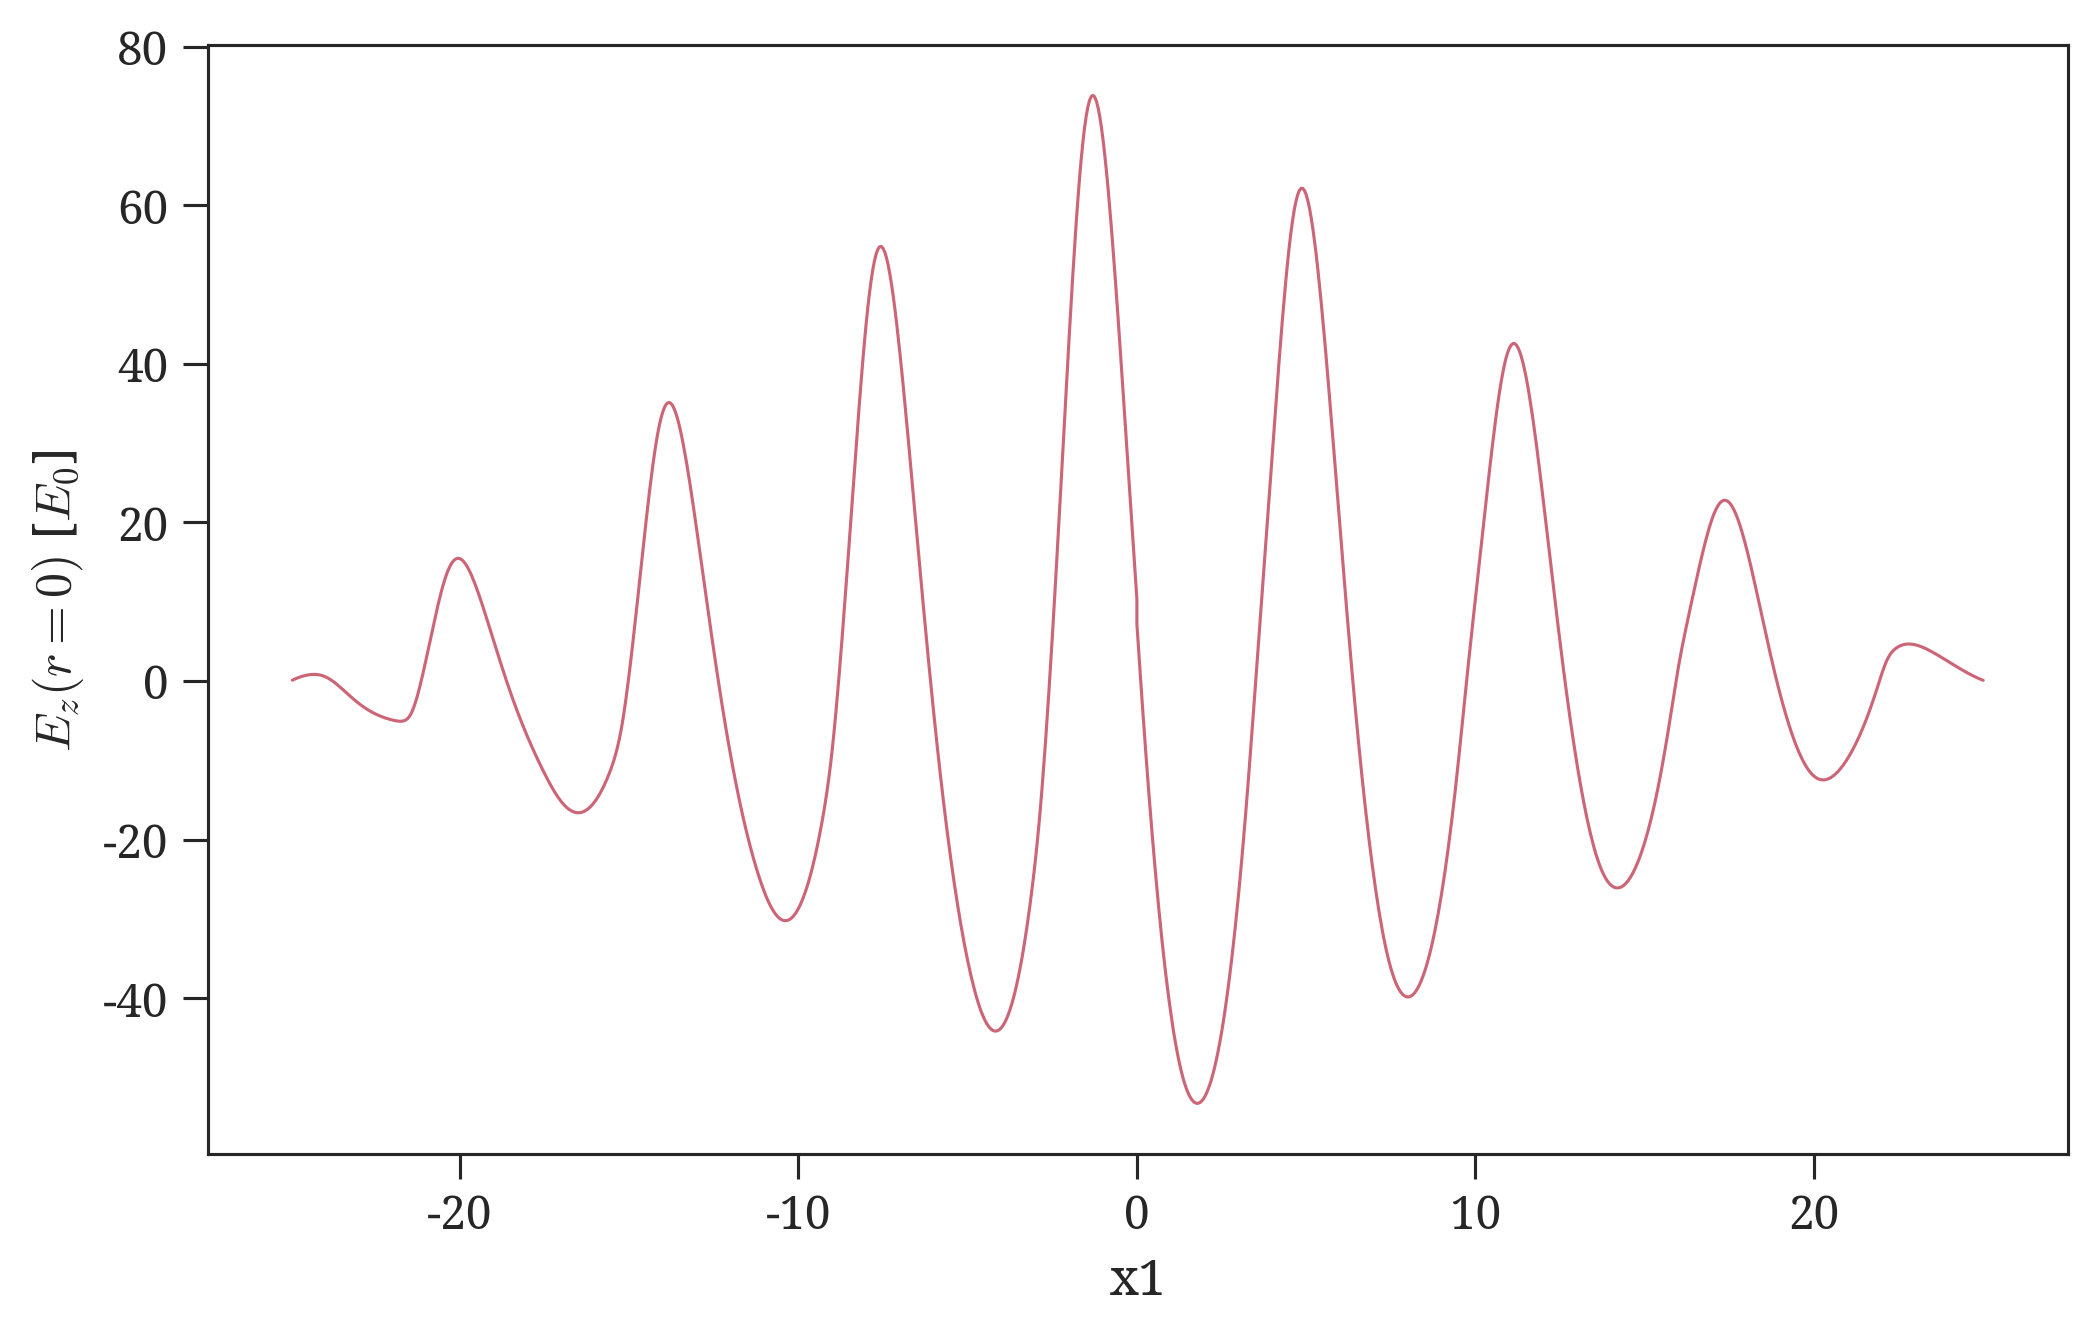

In [145]:

# corr = np.correlate(ds_sample.isel(t=31).plot(), ds_sample.isel(t=30).plot(), mode="full")

corr = xr.apply_ufunc(np.correlate, ds_sample.isel(t=40), ds_sample.isel(t=30), vectorize=True, kwargs=dict(mode='full'), dask='allowed', input_core_dims=[['x1'],['x1']], exclude_dims={'x1'}, output_core_dims=[['x1']], output_dtypes=[float])

x1corr = np.concatenate((ds_sample.x1[1:].to_numpy()+150, np.flip(-(ds_sample.x1.to_numpy()+150))))

corr = corr.assign_coords(x1=x1corr)

corr.plot()
# plt.xlim(-1,1)
# plt.ylim(70,90)

max(corr)['x1'].data

150.05

In [111]:
0.75/0.05

15.0